
### S&P 500 Network Analysis¶
#### Data 620 Final Project
#### Group Memebers: Layla Quinones, Maliat Islam, Karim Hammoud

#### Introduction
The Standard & Poor 500 stock market index (S&P 500) is a data source that is upated and published daily which is widly used as investiment benchmarks for brokers, and to issue credit ratings to determine debt obligations for major companies. It consists of 505 common stocks issued by large-cap companies that trade on American stock exchanges (including the 30 companies that compose the Dow Jones Industrial Average), and covers about 80 percent of the American equity market by capitalization.

In this project we use various web analytics tools to generate multiple network perspectives for each company in the S&P 500. We employ network tools from the networkx library to help uncover relationships between companies from data extracted via web scraping, and from the Yahoo Finance Api available in python. We then conduct sentiment analysis in twitter to uncover sentiments about key companies in the S&P network.


S&P Network via Web Scraping
In this section categorical data for S&P 500 companies were scraped from the following Wikipedia page, and quantitative data containing the weights assigned to each company was downloaded from Slickcharts.com. Information from both data sources were merged and used to generate an initial network graph, which was then used to create a projected network to extract insights between companies. Please refer to comments in the code chunks below for more detailed information on the workflow.

In [61]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [62]:

# Load the required libraries for project
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import warnings
from networkx.algorithms import bipartite as bi
import pandas_datareader.data as reader
import datetime as dt
import statsmodels.api as sm
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
import tweepy
from textblob import TextBlob
from wordcloud import wordcloud
import re
import seaborn as sns
from scipy import stats as stat
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import json
import yfinance as yf
import sys
import jsonpickle
from afinn import Afinn

In [63]:
# There are 2 tables on the Wikipedia page, we are interested in the first one only
# Using pandas library to scrape the table from the page
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
wiki = payload[0] #first table only

#####Data Cleaning######
#renaming the columns
wiki.columns = ['Symbol', 'Security', 'filings', 'Sector', 'Sub_Industry', 'Headquarters', 'Date_added', 'CIK', 'Founded']

# Split the city and state and create new column for state
wiki['State'] = wiki['Headquarters'].apply(lambda x: x.split(',')[1] if ',' in x else '')

# We noticed all of the empty values in State column are related to New York City
wiki['State'] = wiki['State'].str.strip()
wiki['State'] = wiki['State'].replace('', 'New York')

wiki.at[56,'State']='Virginia'
wiki.at[73,'State']='Massachusetts'
wiki.at[134,'State']='Washington'
wiki.at[274,'State']='Illinois'
wiki.head()

Symbol             Security  filings                  Sector  \
0    MMM                   3M  reports             Industrials   
1    ABT  Abbott Laboratories  reports             Health Care   
2   ABBV               AbbVie  reports             Health Care   
3   ABMD              Abiomed  reports             Health Care   
4    ACN            Accenture  reports  Information Technology   

                     Sub_Industry             Headquarters  Date_added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1976-08-09   
1           Health Care Equipment  North Chicago, Illinois  1964-03-31   
2                 Pharmaceuticals  North Chicago, Illinois  2012-12-31   
3           Health Care Equipment   Danvers, Massachusetts  2018-05-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded          State  
0    66740         1902      Minnesota  
1     1800         1888       Illinois  
2  1551152  2013 (1888)       Illinois  
3   815094         1981  Massachusetts  
4  1467373         1989        Ireland

In [64]:
# Get weights and price per stock from github - from slickcharts.com/sp500
weights=pd.read_csv('https://raw.githubusercontent.com/akarimhammoud/DATA-620/main/Week_6_final%20project/weights.csv')
weights.drop(['#', 'Chg', '% Chg'], axis='columns', inplace=True)
weights.rename(columns={list(weights.columns)[3]: 'Price'}, inplace=True, errors='raise')
weights.head()

Company Symbol    Weight        Price
0             Apple Inc.   AAPL  6.151855       145.08
1  Microsoft Corporation   MSFT  5.720618       277.85
2        Amazon.com Inc.   AMZN  4.379672     3,716.00
3  Facebook Inc. Class A     FB  2.267526       350.60
4  Alphabet Inc. Class A  GOOGL  2.059196     2,508.49

In [65]:
# Merge both datasets
df = pd.merge(wiki, weights, on ='Symbol',how ='inner')
df.head()

Symbol             Security  filings                  Sector  \
0    MMM                   3M  reports             Industrials   
1    ABT  Abbott Laboratories  reports             Health Care   
2   ABBV               AbbVie  reports             Health Care   
3   ABMD              Abiomed  reports             Health Care   
4    ACN            Accenture  reports  Information Technology   

                     Sub_Industry             Headquarters  Date_added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1976-08-09   
1           Health Care Equipment  North Chicago, Illinois  1964-03-31   
2                 Pharmaceuticals  North Chicago, Illinois  2012-12-31   
3           Health Care Equipment   Danvers, Massachusetts  2018-05-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded          State                Company    Weight  \
0    66740         1902      Minnesota             3M Company  0.313848   
1     1800         1888       Illinois    Abbott Laboratories  0.580172   
2  1551152  2013 (1888)       Illinois            AbbVie Inc.  0.561722   
3   815094         1981  Massachusetts           ABIOMED Inc.  0.040224   
4  1467373         1989        Ireland  Accenture Plc Class A  0.538042   

       Price  
0     201.00  
1     119.74  
2     116.58  
3     324.77  
4     312.62


#### Initial Network Creation
The table above was used to create an initial network with States and Sectors as nodes. We were interested in first identifying the states and sectors with the highest number of connections, which may indicate key players in the S&P network.

In [66]:
#Network nodes (State and Sector)
G = nx.Graph()
G = nx.from_pandas_edgelist(df, source= 'State', target='Sector',edge_attr=True)

#add the attributes
nx.set_node_attributes(G, df['Weight'], 'Weight')
nx.set_node_attributes(G, df['Sub_Industry'], 'Sub_Industry')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 56
Number of edges: 205
Average degree:   7.3214


In [67]:

#Fully connected network with one component
print(f"Number of components: {nx.number_connected_components(G)} \nIs it fully connected? {nx.is_connected(G)}")

Number of components: 1 
Is it fully connected? True


In [68]:
# Display top degree States (States with most connections)
sector = list(df.Sector.unique())
state = list(df.State.unique())
headquarter = list(df.Headquarters.unique())

#NUMBER OF CONNECTIONS FOR HEADQUARTERS
gd=pd.DataFrame(G.degree(state)).sort_values(1,ascending =False).rename({0:'State:',1:'DEGREE'}, axis=1).set_index("State:")
print("Degree: \n", gd[0:10])

Degree: 
                 DEGREE
State:                
California          11
New York            11
Texas               11
Pennsylvania         9
Illinois             9
Ohio                 9
Minnesota            7
Connecticut          7
Florida              7
North Carolina       7


In [69]:
#NUMBER OF CONNECTIONS FOR SECTORS
gd=pd.DataFrame(G.degree(sector)).sort_values(1,ascending =False).rename({0:'Sector:',1:'DEGREE'}, axis=1).set_index("Sector:")
print("Degree: \n", gd)

Degree: 
                         DEGREE
Sector:                       
Industrials                 27
Consumer Discretionary      26
Financials                  26
Health Care                 22
Information Technology      22
Utilities                   19
Materials                   19
Consumer Staples            16
Real Estate                 14
Communication Services       8
Energy                       6


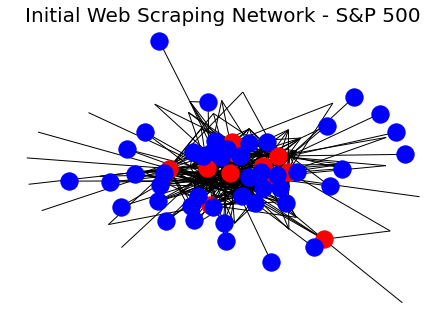

In [70]:
#visualize the network of sectors and states
nx.draw(G, nodelist = sector, node_color = 'red')
nx.draw(G, nodelist = state, node_color = 'blue')
plt.title('Initial Web Scraping Network - S&P 500', fontsize = 20, color = 'black')
plt.show()


#### Initial Analysis
From the initial network that was generated based on web scraping and weighted data, we can clearly see that key states that play a large role in this network include Texas, California and New York (with a total of 11 connections to companies in the network. On the other hand we can see that the key industries that play a large role in this network include Industrials, Consumer Discretionary and Financials with 27 and 26 connections respectivley.

It is interesting to note that these findings reflect what was expected in that Texas and California, besides being in the top 3 larges states in the country, has become a popular location for companies to move due to reasons such as lower income tax and having major cities with large tech company communities (SOURCE. In addition New York City, being the home of the New York Stock Exchange, has always been attractive for companies due to the prestige and image associated with that location. (SOURCE

#### Projected Networks
We wanted to get a better idea of the relationships between states and sectors so we continued our analysis by employing a network projection for each, visualizing and analyzing centrality measures.

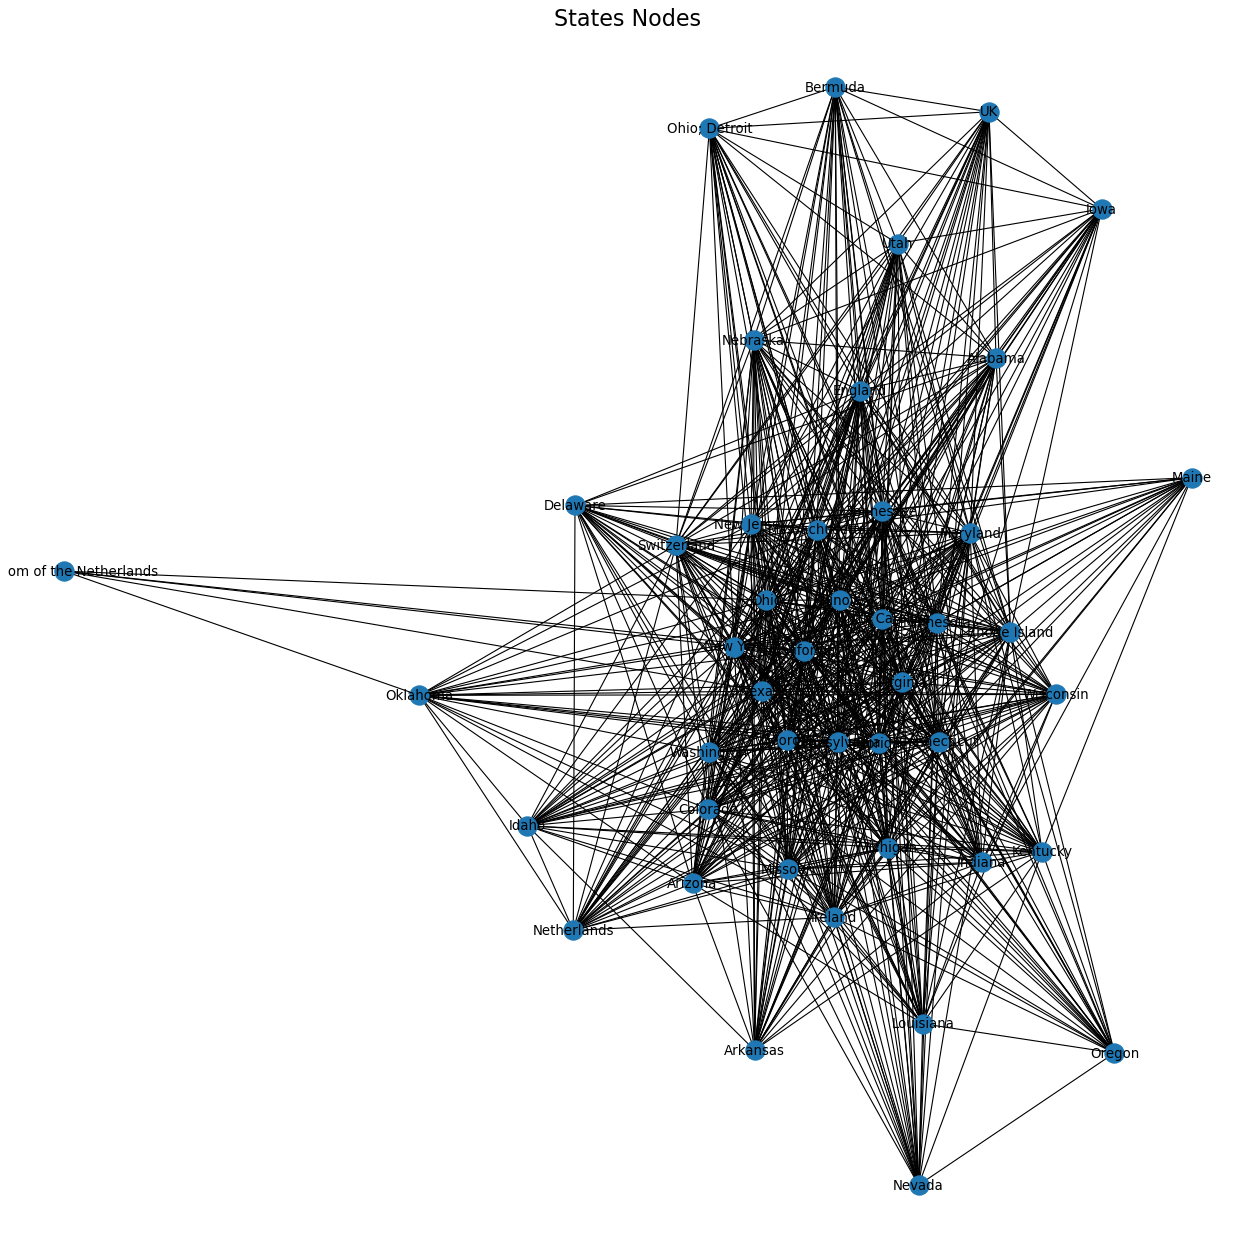

In [71]:
# create an affiliation network (spring layout)
netstate = bi.weighted_projected_graph(G, state)
netsector = bi.weighted_projected_graph(G, sector)

#Visualize entire  network of states
pos = nx.spring_layout(netstate)
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
nx.draw_networkx_nodes(netstate,pos)
nx.draw_networkx_edges(netstate,pos)
nx.draw_networkx_labels(netstate,pos)
plt.title('States Nodes',size = 20)

cut = 1.00
plt.show()

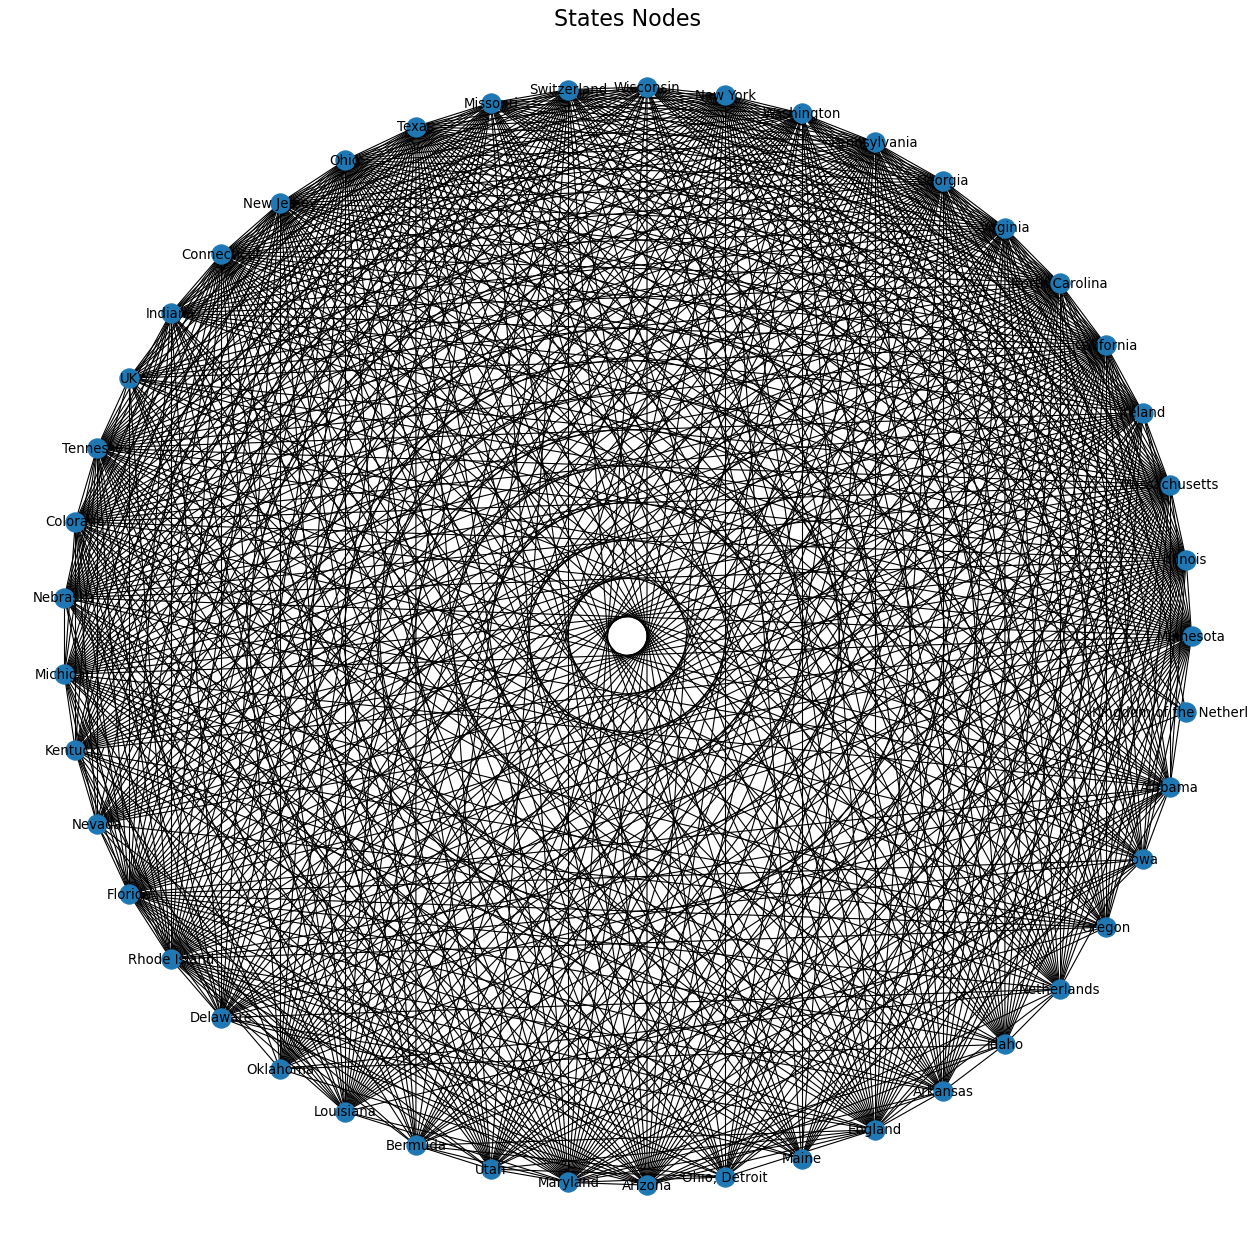

In [72]:
#Visualize entire  network of states (circular)
pos = positions=nx.circular_layout(netstate)
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
nx.draw_networkx_nodes(netstate,pos)
nx.draw_networkx_edges(netstate,pos)
nx.draw_networkx_labels(netstate,pos)
plt.title('States Nodes',size = 20)

cut = 1.00
plt.show()

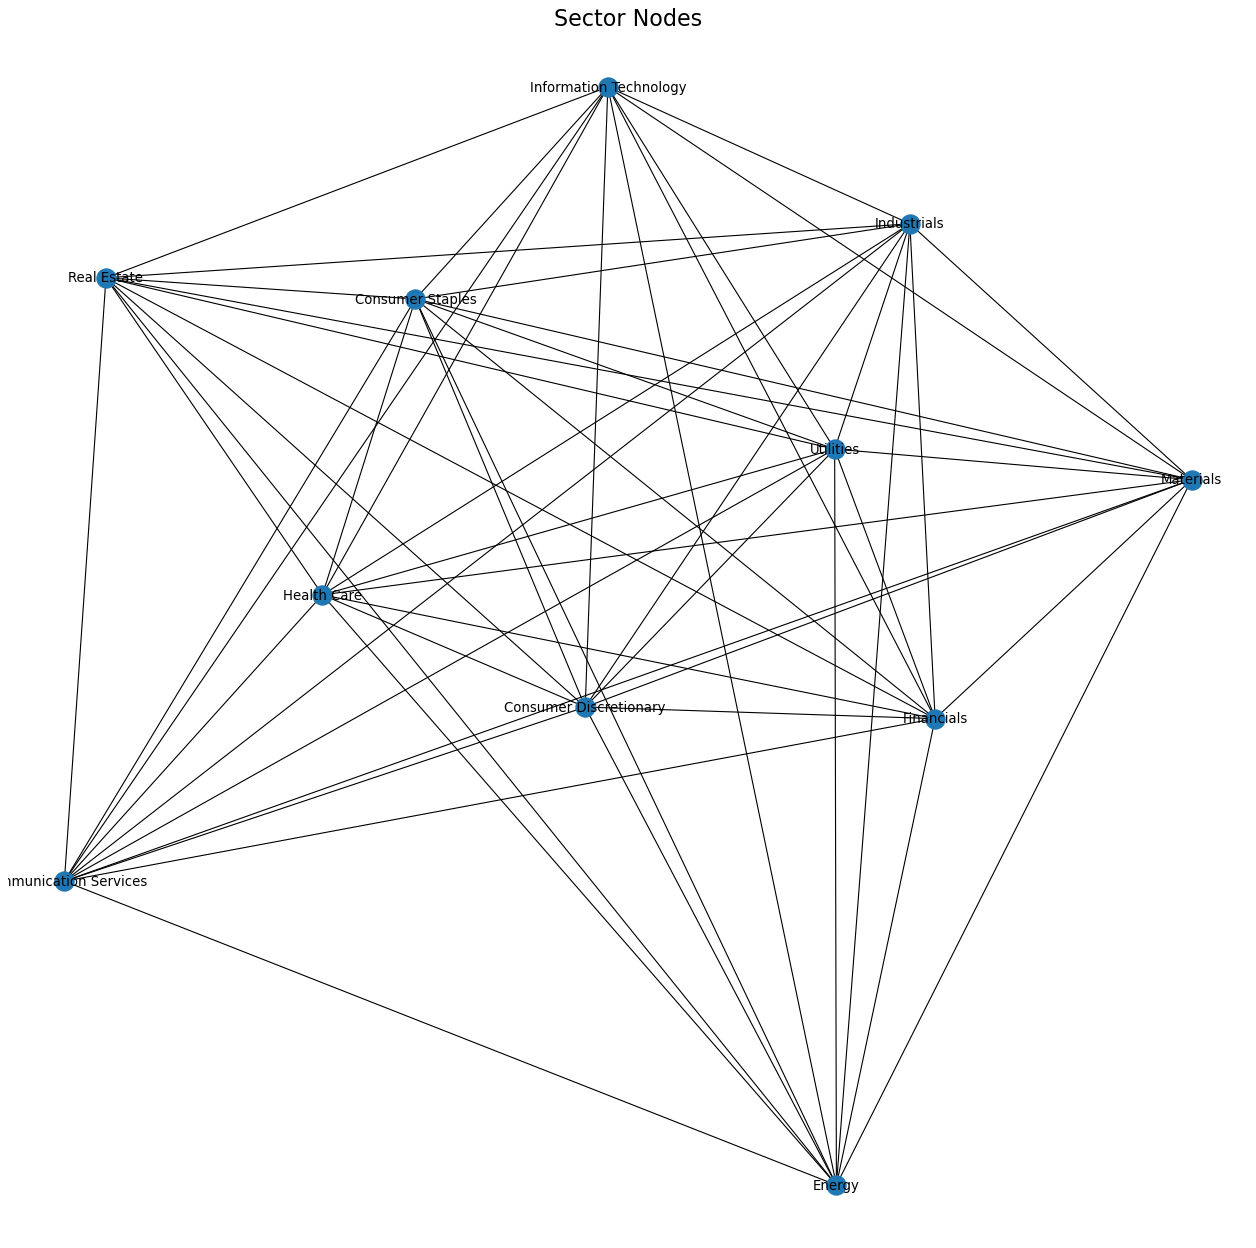

In [73]:
#Visualize entire  network of sectors
pos = nx.spring_layout(netsector)
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
nx.draw_networkx_nodes(netsector,pos)
nx.draw_networkx_edges(netsector,pos)
nx.draw_networkx_labels(netsector,pos)
plt.title('Sector Nodes',size = 20)

cut = 1.00
plt.show()

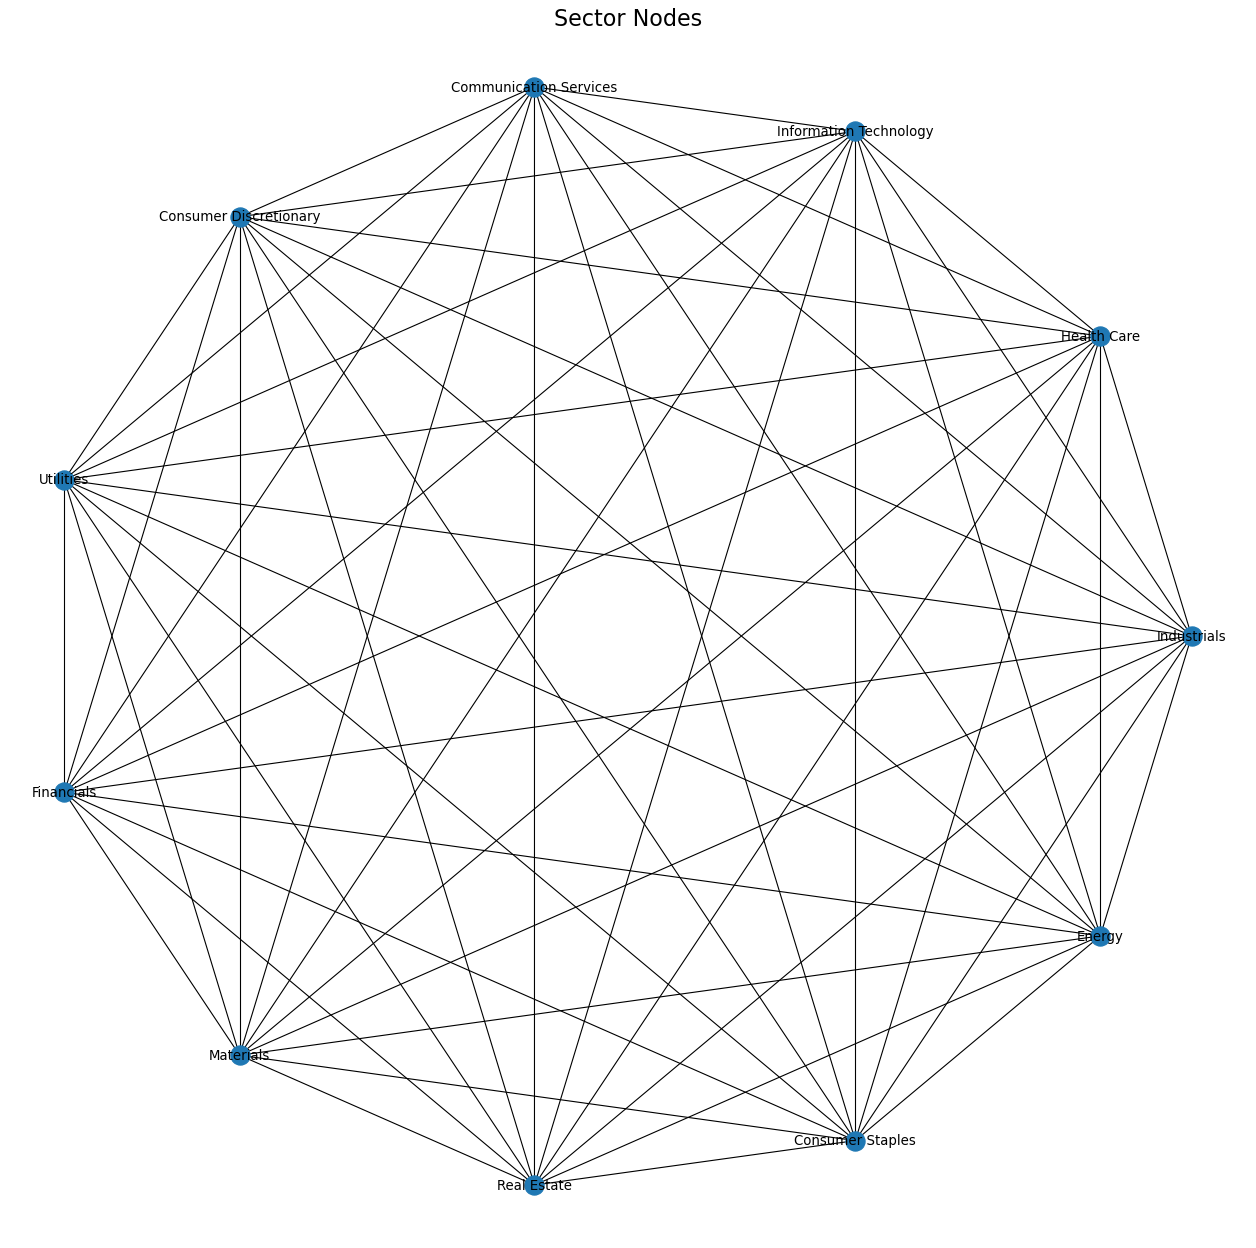

In [74]:
#Visualize entire  network of states (circular)
pos = positions=nx.circular_layout(netsector)
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
nx.draw_networkx_nodes(netsector,pos)
nx.draw_networkx_edges(netsector,pos)
nx.draw_networkx_labels(netsector,pos)
plt.title('Sector Nodes',size = 20)

cut = 1.00
plt.show()

#### Measures of Centrality

In [75]:
#closeness
closeness = nx.closeness_centrality(netstate)
#betweenness
betweenness = nx.betweenness_centrality(netstate)
#eigenvector
eigenvector = nx.eigenvector_centrality(netstate)

#put everything in a dataframe for easy comparison
closenessDF = pd.DataFrame.from_dict(closeness.items())
closenessDF.rename(columns={0: 'State',1: 'Closeness'},inplace=True, errors='raise')

betweennessDF = pd.DataFrame.from_dict(betweenness.items())
betweennessDF.rename(columns={0: 'State',1: 'Betweenness'},inplace=True, errors='raise')

eigenvectorDF = pd.DataFrame.from_dict(eigenvector.items())
eigenvectorDF.rename(columns={0: 'State',1: 'Eigenvector'},inplace=True, errors='raise')

centDF = closenessDF.merge(betweennessDF, how='outer',on='State')
centDF = centDF.merge(eigenvectorDF, how='outer',on='State')
centDF.sort_values(by=['Closeness'],ascending=False)[0:10]

State  Closeness  Betweenness  Eigenvector
15            Ohio   1.000000     0.018931     0.177163
4       California   1.000000     0.018931     0.177163
10        New York   1.000000     0.018931     0.177163
14           Texas   1.000000     0.018931     0.177163
2    Massachusetts   0.977778     0.009575     0.176556
1         Illinois   0.977778     0.009575     0.176556
5   North Carolina   0.977778     0.009575     0.176556
8     Pennsylvania   0.977778     0.009575     0.176556
17     Connecticut   0.977778     0.009575     0.176556
0        Minnesota   0.956522     0.008314     0.173826

In [76]:
# Count the number of companies per state
count = df.groupby('State').count()
count = count.iloc[:, 0]
count.sort_values(ascending=False)[0:8]

State
California       74
New York         56
Texas            40
Illinois         35
Massachusetts    22
Pennsylvania     18
Ohio             18
Georgia          17
Name: Symbol, dtype: int64

In [77]:
#closeness
closeness2 = nx.closeness_centrality(netsector)
#betweenness
betweenness2 = nx.betweenness_centrality(netsector)
#eigenvector
eigenvector2 = nx.eigenvector_centrality(netsector)

#put everything in a dataframe for easy comparison
closenessDF2 = pd.DataFrame.from_dict(closeness2.items())
closenessDF2.rename(columns={0: 'Sector',1: 'Closeness'},inplace=True, errors='raise')

betweennessDF2 = pd.DataFrame.from_dict(betweenness2.items())
betweennessDF2.rename(columns={0: 'Sector',1: 'Betweenness'},inplace=True, errors='raise')

eigenvectorDF2 = pd.DataFrame.from_dict(eigenvector2.items())
eigenvectorDF2.rename(columns={0: 'Sector',1: 'Eigenvector'},inplace=True, errors='raise')

centDF2 = closenessDF2.merge(betweennessDF2, how='outer',on='Sector')
centDF2 = centDF2.merge(eigenvectorDF2, how='outer',on='Sector')
centDF2.sort_values(by=['Closeness'],ascending=False)[0:10]

Sector  Closeness  Betweenness  Eigenvector
0             Industrials        1.0          0.0     0.301511
1             Health Care        1.0          0.0     0.301511
2  Information Technology        1.0          0.0     0.301511
3  Communication Services        1.0          0.0     0.301511
4  Consumer Discretionary        1.0          0.0     0.301511
5               Utilities        1.0          0.0     0.301511
6              Financials        1.0          0.0     0.301511
7               Materials        1.0          0.0     0.301511
8             Real Estate        1.0          0.0     0.301511
9        Consumer Staples        1.0          0.0     0.301511

In [78]:
# Count the number of companies per state
count2 = df.groupby('Sector').count()
count2 = count2.iloc[:, 0]
count2.sort_values(ascending=False)[0:8]

Sector
Industrials               74
Information Technology    74
Financials                65
Consumer Discretionary    63
Health Care               63
Consumer Staples          32
Real Estate               29
Materials                 28
Name: Symbol, dtype: int64

#### Projected Network Analysis
From the above projected network analysis we can confirm that California, New York and Texas continue to lead in terms of network importance - they have the same closeness, betweenness and eignenvector centrality measurments. Interestingly enough, we see that Ohio is emerging from this analysis as a fourth state valued at the same importance as the ones previously identified from the initial network. Despite the fact that it does not have nearly as many companies located in the state, centrality measures in the projected networks show that Ohio is prominent contributor in this network. It would interesting to analyze companies within this state to determine which ones are causing the state to gain such prominence.

Centrality measures for the sectors projected network did not provide any further insight into relationships between nodes because all measurements were identicle.

#### Island Method - States
After analyzing the projected networks for states, we decided to proceed with implementing the island method to further reduce the network and incover relationships between groups of states.

In [79]:
# Trim Edges
#This function trims connections with a weight of 1
def trim_edges(g, weight = 1):
    edges = []
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight']> weight:
            x = float(edata['weight'])
            edges.append((f,to,x))
    g2.add_weighted_edges_from(edges)
    return g2

# Island Method
#Employs trim edegs for a range of weights (5 iterations)
def island_method(g, iterations=5):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    
    #size of step
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx, step)]

In [80]:
# Run the island method on state projected network
state_island = island_method(netstate)

#create a Dataframe for display of subnetwork data
dataList = []
for i in state_island:
    dataList.append((i[0], nx.number_of_nodes(i[1]), nx.number_of_edges(i[1]), nx.number_connected_components(i[1])))
pd.DataFrame(dataList, columns =['Threshold', 'Nodes', 'Edges', '# Connected Components'])

Threshold  Nodes  Edges  # Connected Components
0          1     37    462                       1
1          3     25    217                       1
2          5     18     87                       1
3          7      6     14                       1
4          9      3      3                       1

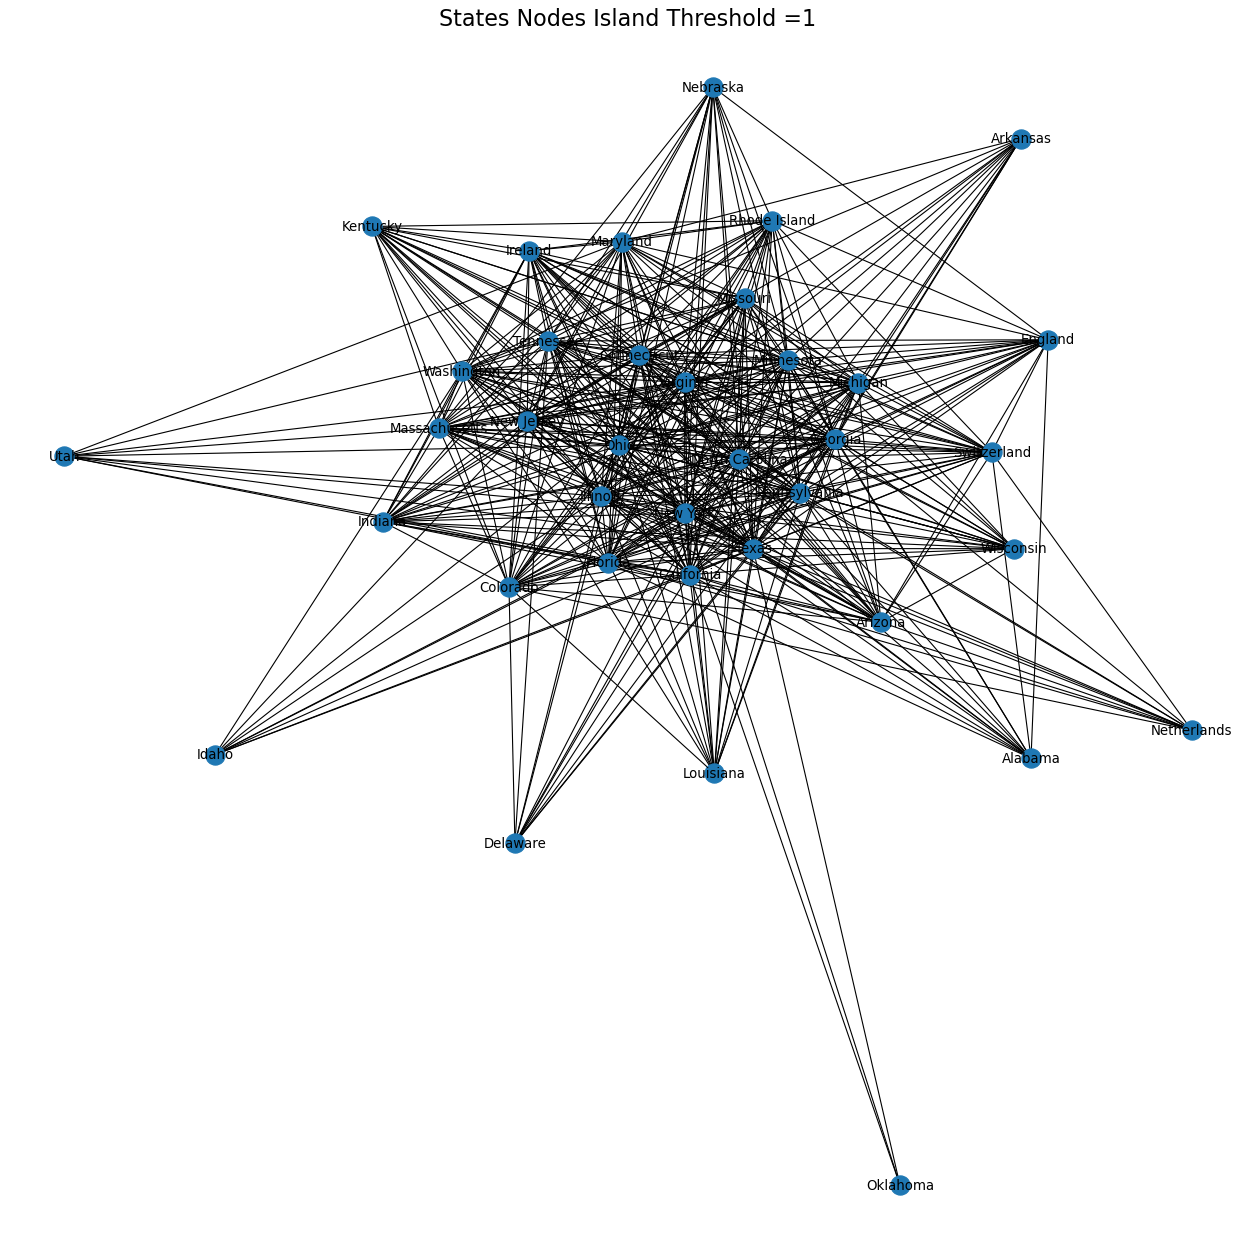

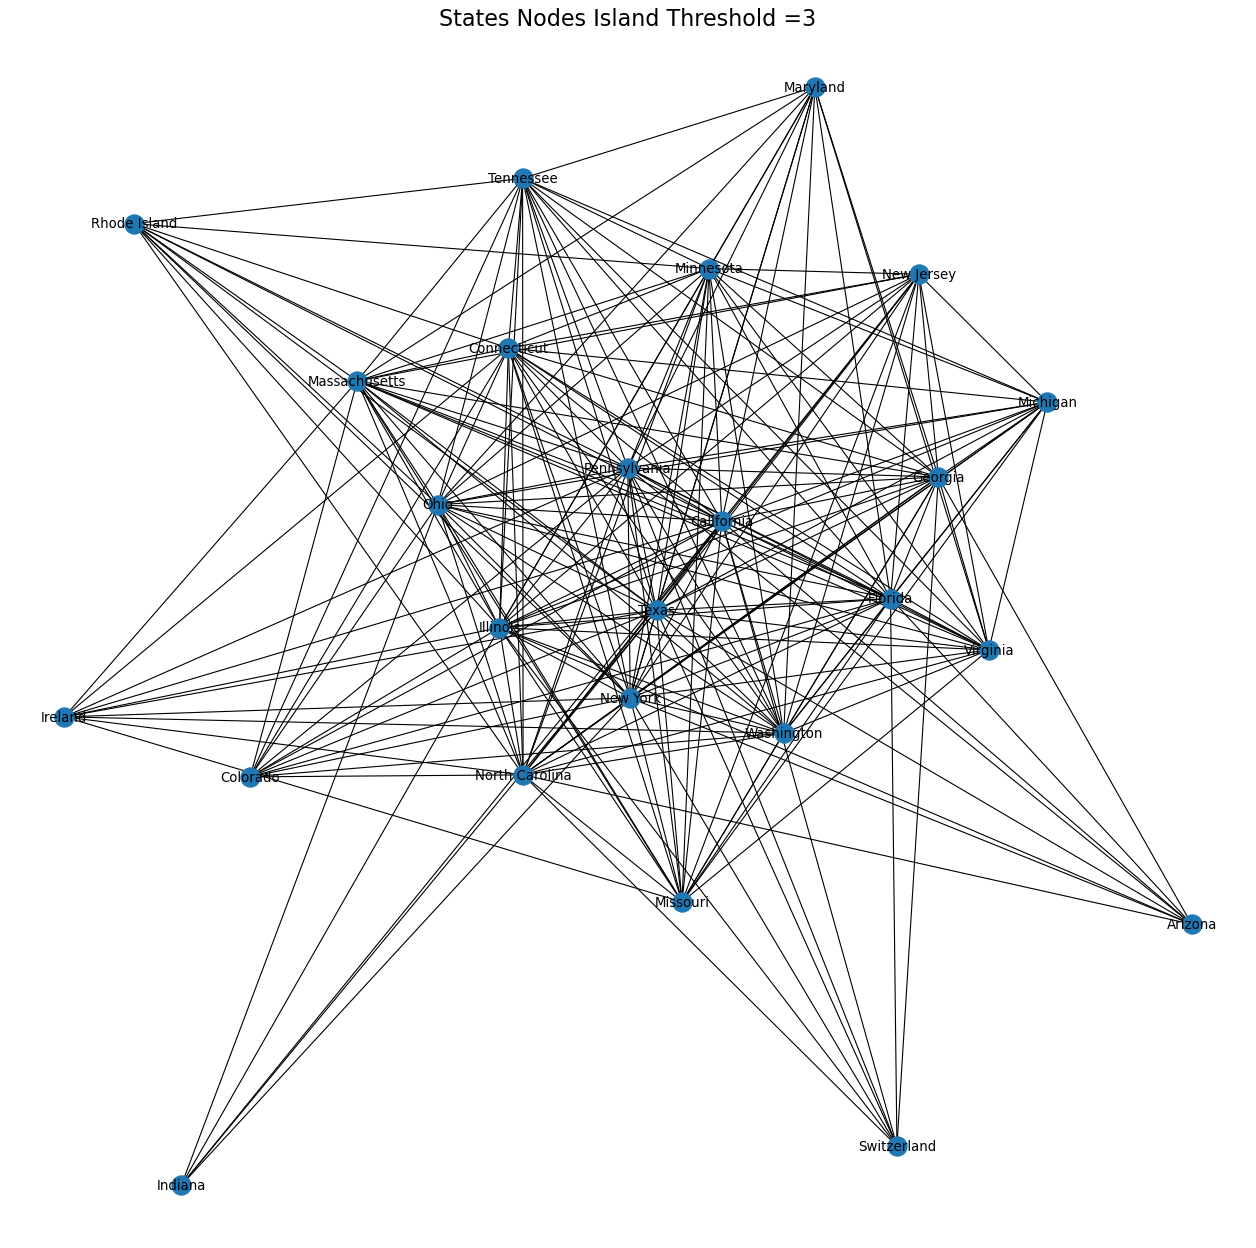

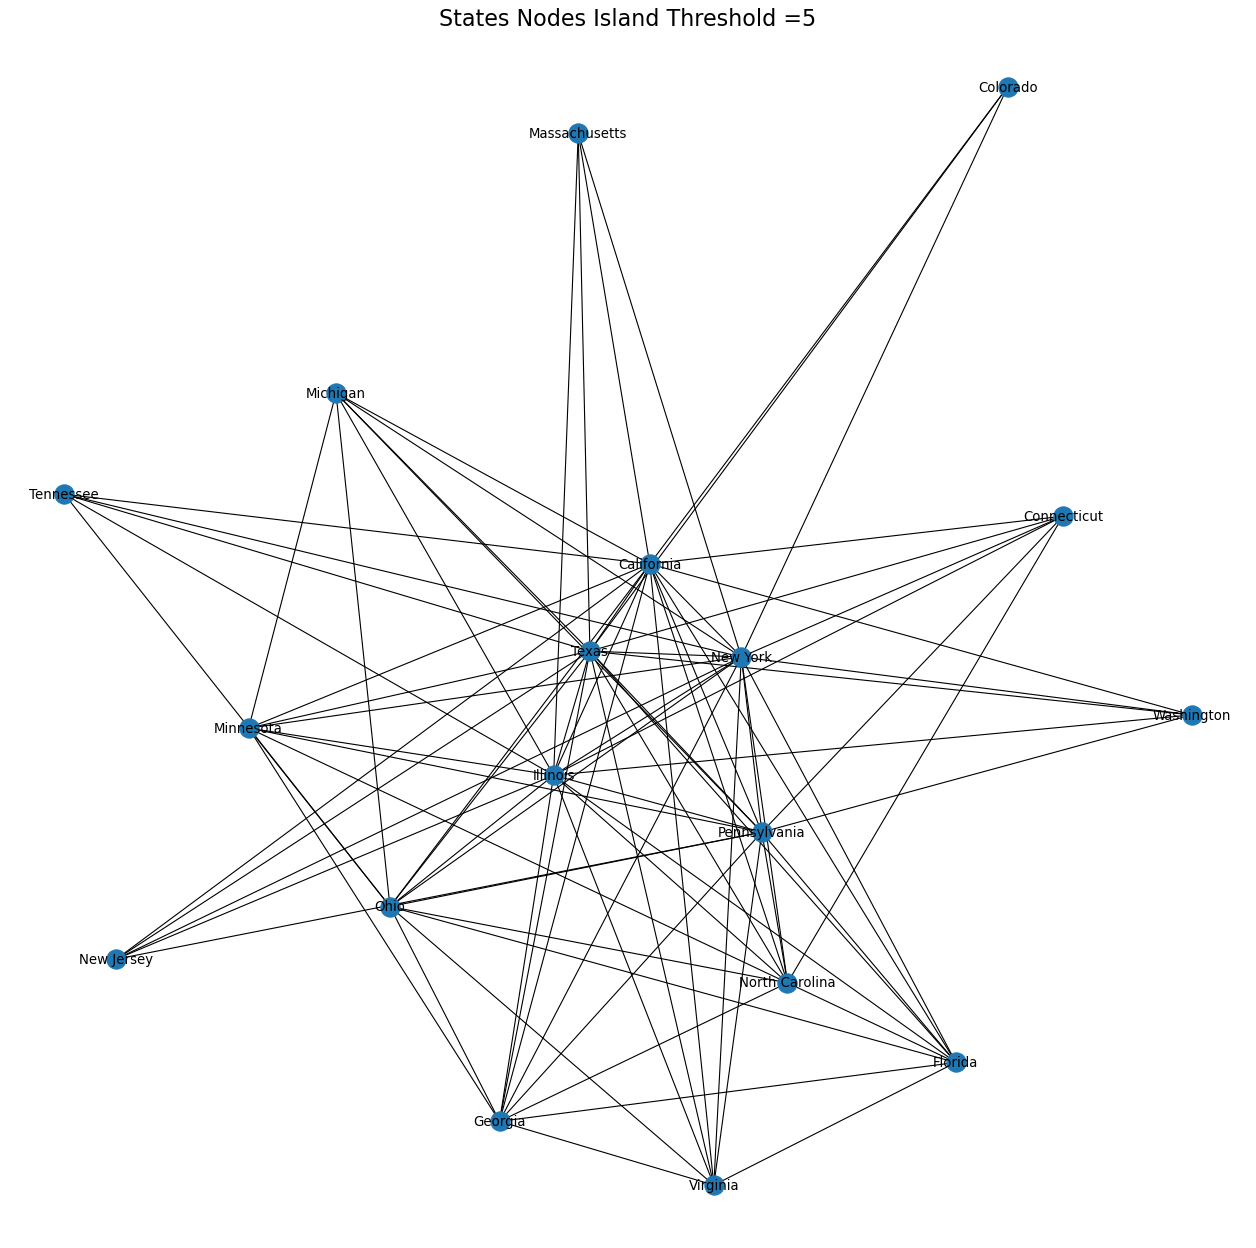

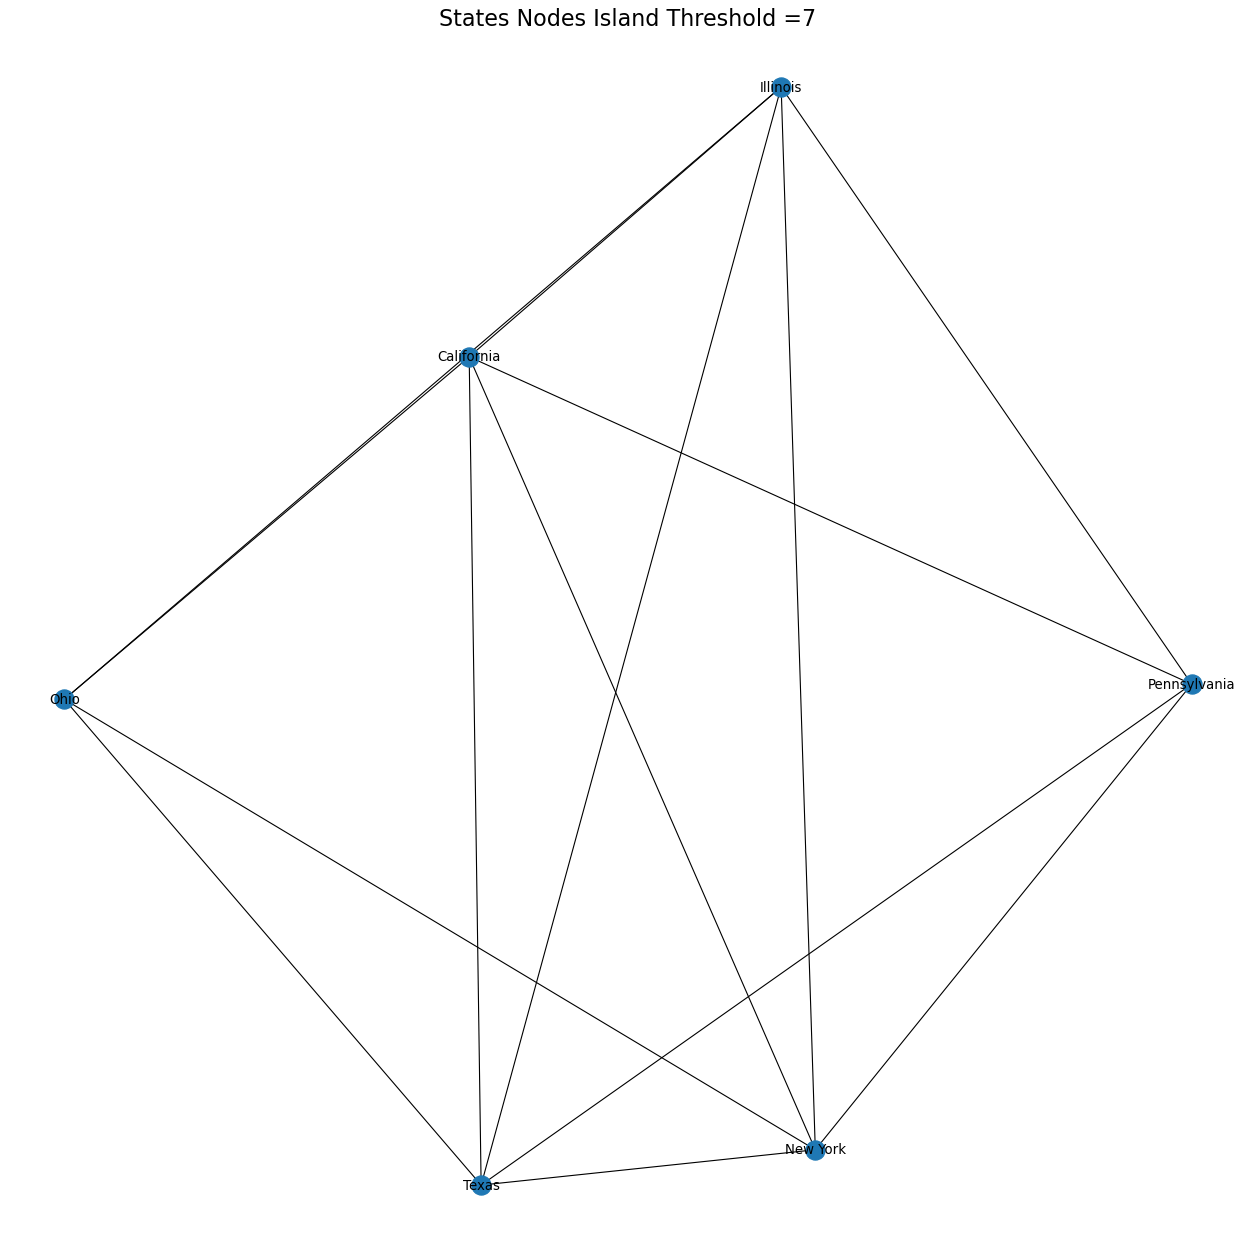

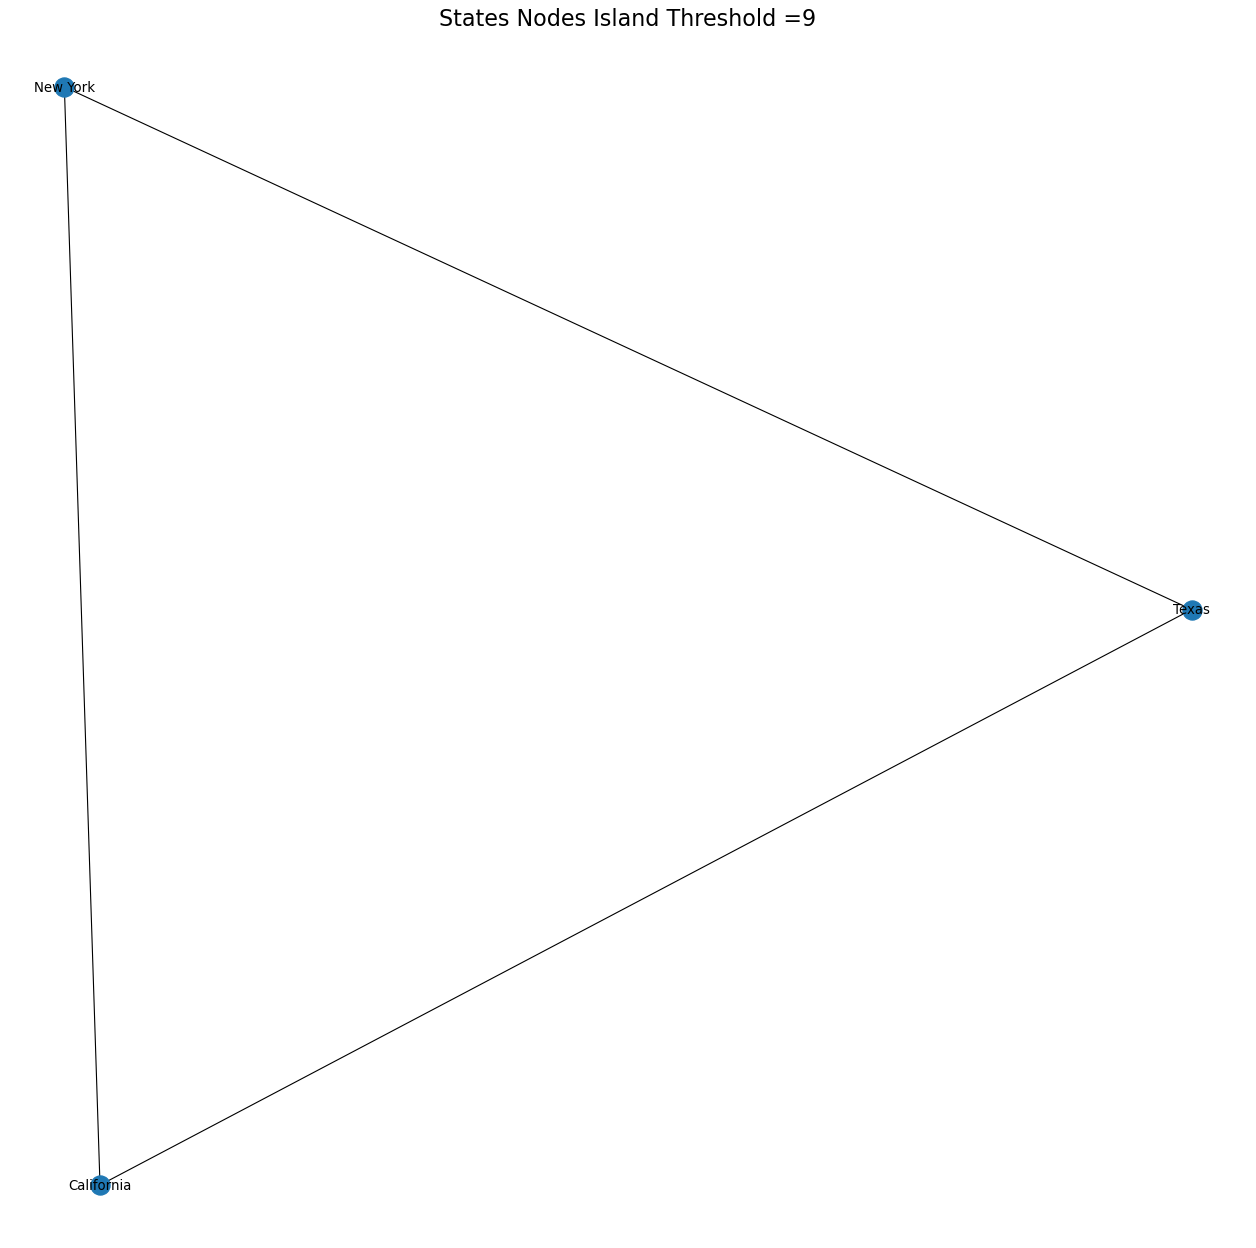

In [81]:
for i in range(len(state_island)):
    #Visualize sub-networks (islands)
    pos = nx.spring_layout(state_island[i][1])
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    nx.draw_networkx_nodes(state_island[i][1],pos)
    nx.draw_networkx_edges(state_island[i][1],pos)
    nx.draw_networkx_labels(state_island[i][1],pos)
    plt.title('States Nodes Island Threshold =' + str(state_island[i][0]),size = 20)

    cut = 1.00
    plt.show()

#### States Projected Network - Island Method Analysis
As seen in the visualization above, the states within specific sub-networks are now begginig to cluster together. In each slice of the network we start to see less promonant states drop off until we reach the last graph where you can see that New York, California and Texas are the most prominent nodes in this network - which agrees with previous analysis. It is interesting to note that in this perspective, we do not see Ohio included in the last graph which indicates that it is in fact, not as prominent as the other three as previously thought.

#### Island Method - Sectors
After analyzing the projected networks for sectors, we decided to proceed with implementing the island method to further reduce the network and incover relationships between groups of sectors (since previous analysis did not yeild any useful insights)

In [82]:
# Run the island method on state projected network
state_island2 = island_method(netsector)

#create a Dataframe for display of subnetwork data
dataList2 = []

for i in state_island2:
    dataList2.append((i[0], nx.number_of_nodes(i[1]), nx.number_of_edges(i[1]), nx.number_connected_components(i[1])))

pd.DataFrame(dataList2, columns =['Threshold', 'Nodes', 'Edges', '# Connected Components'])

Threshold  Nodes  Edges  # Connected Components
0          3     11     54                       1
1          6     10     39                       1
2          9      9     31                       1
3         12      8     20                       1
4         15      6      8                       1
5         18      3      2                       1

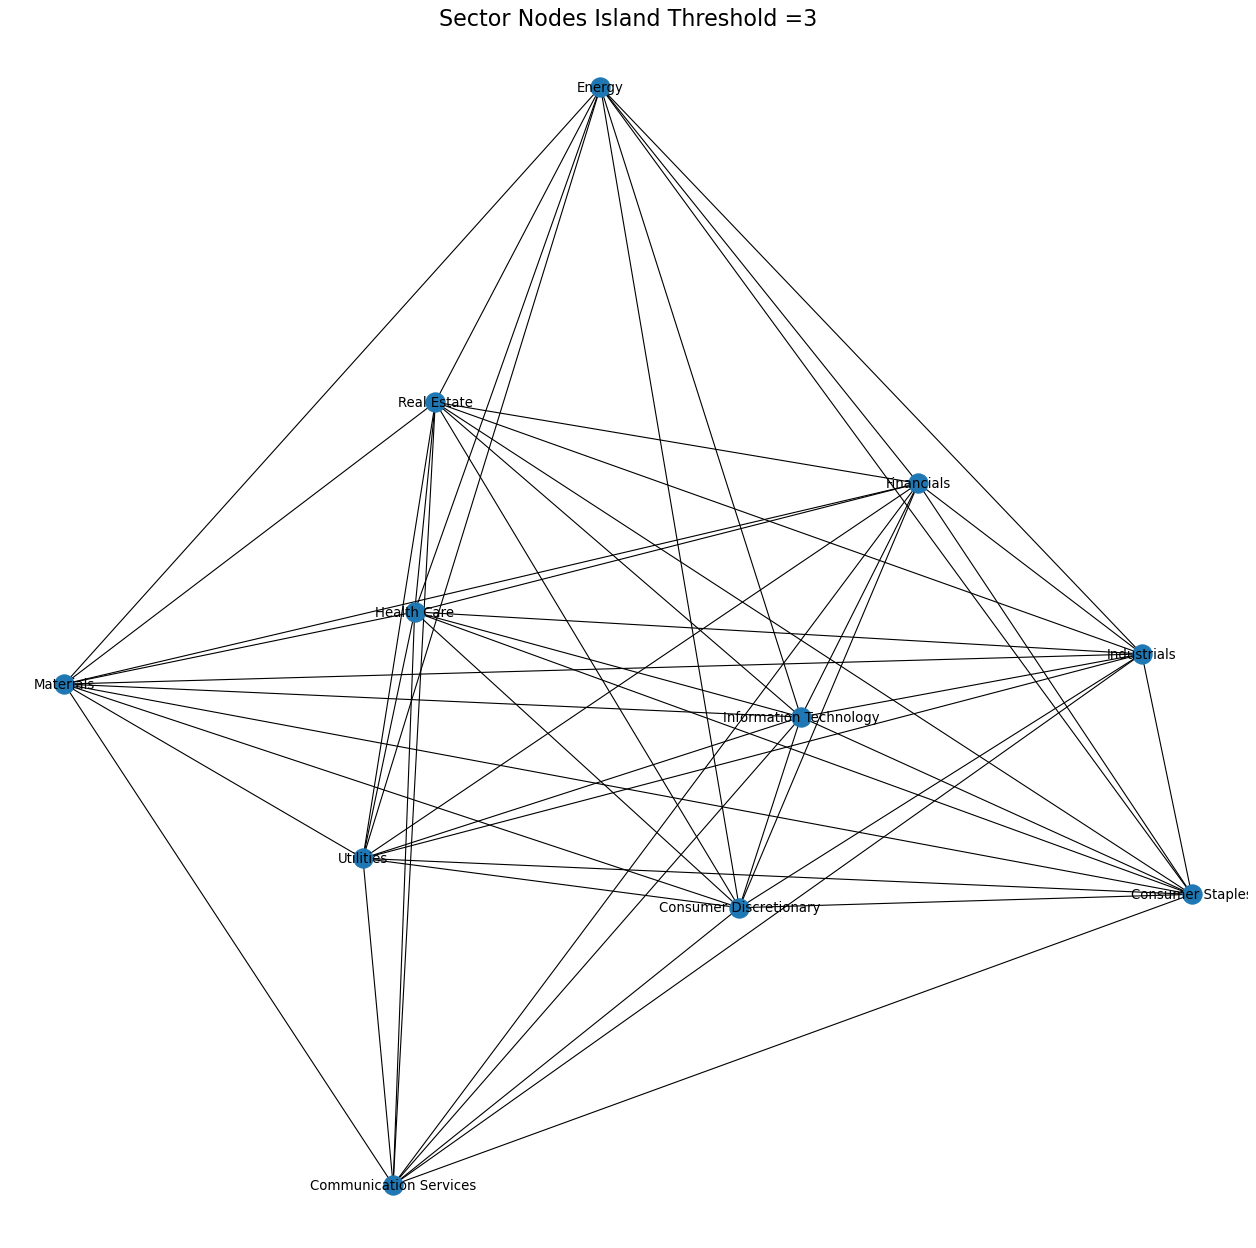

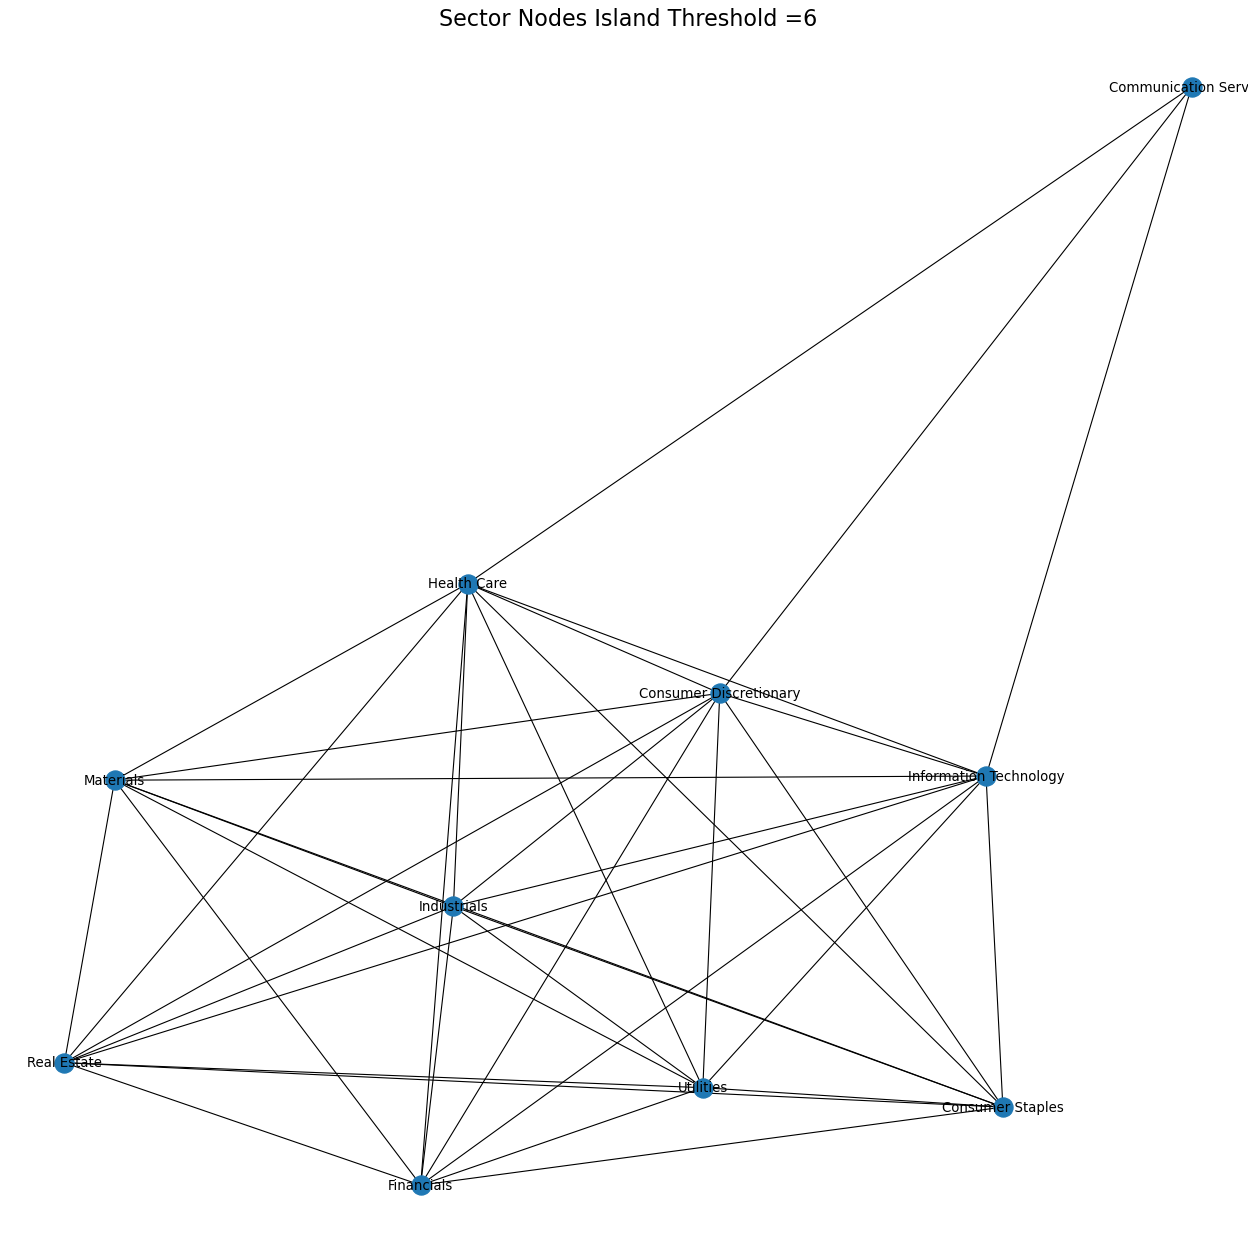

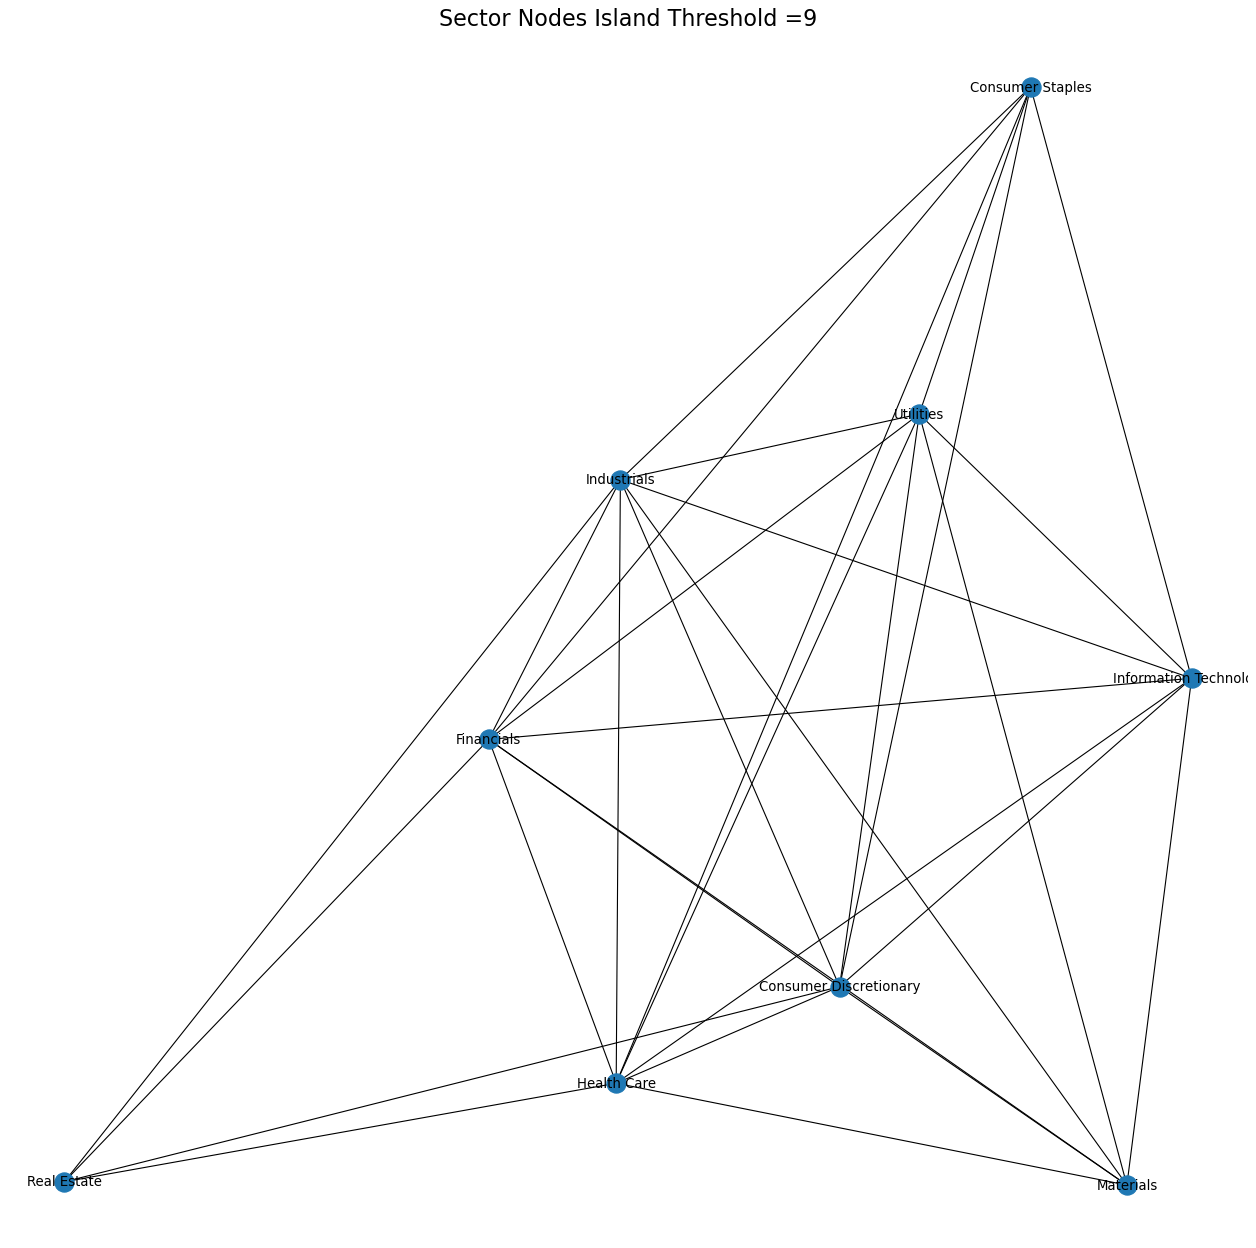

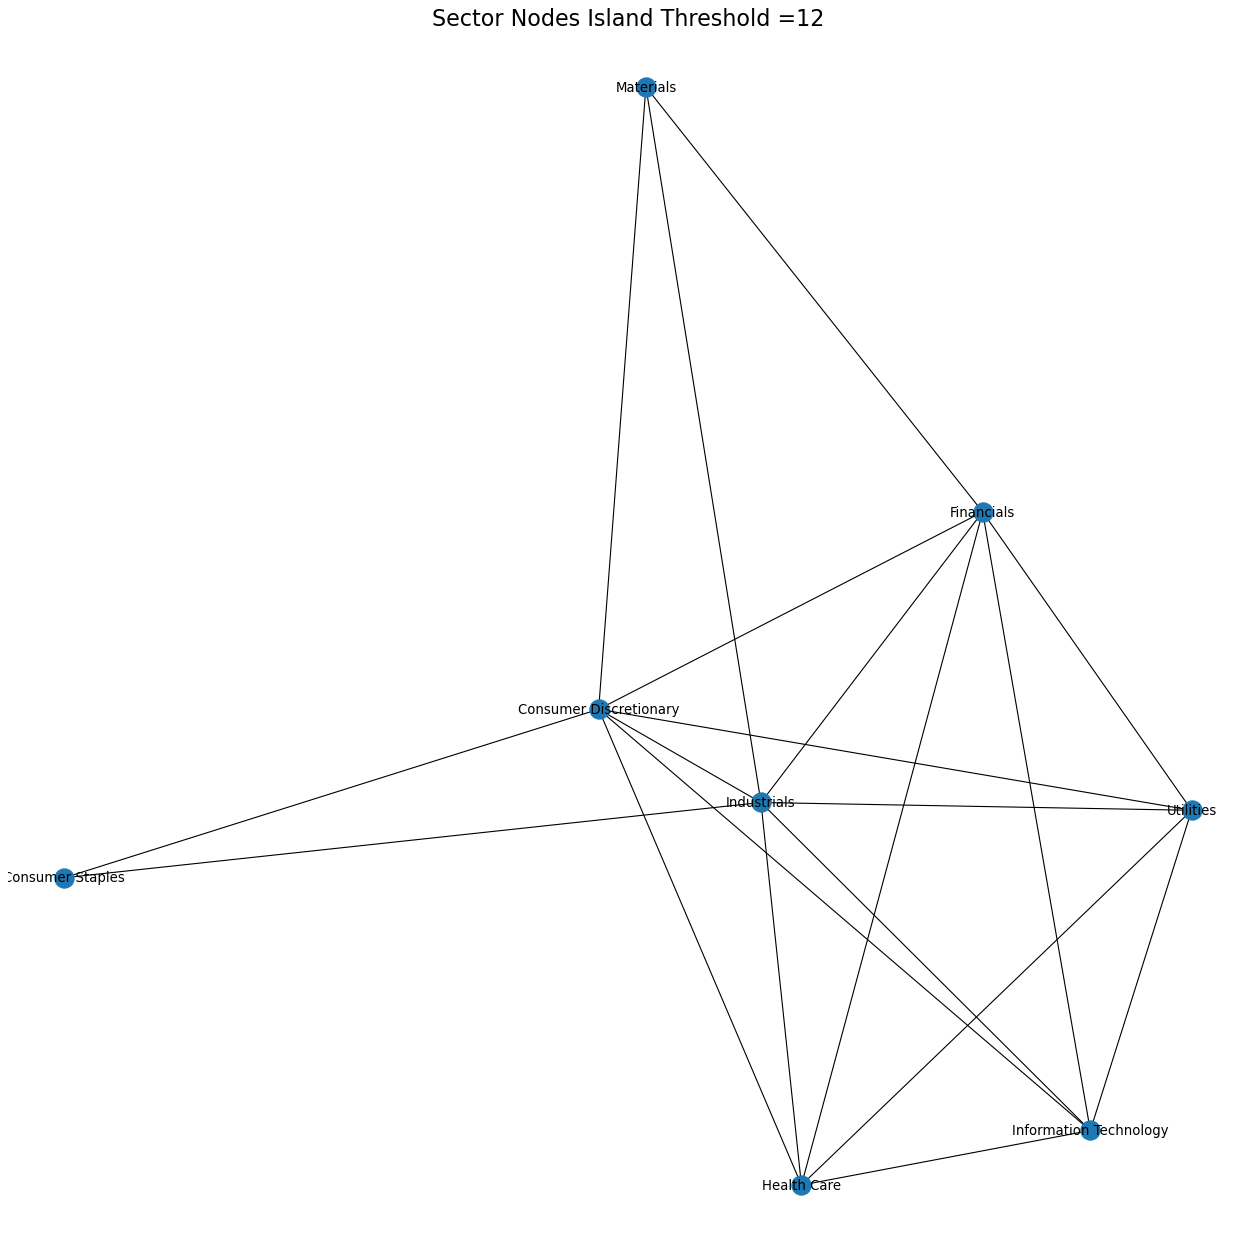

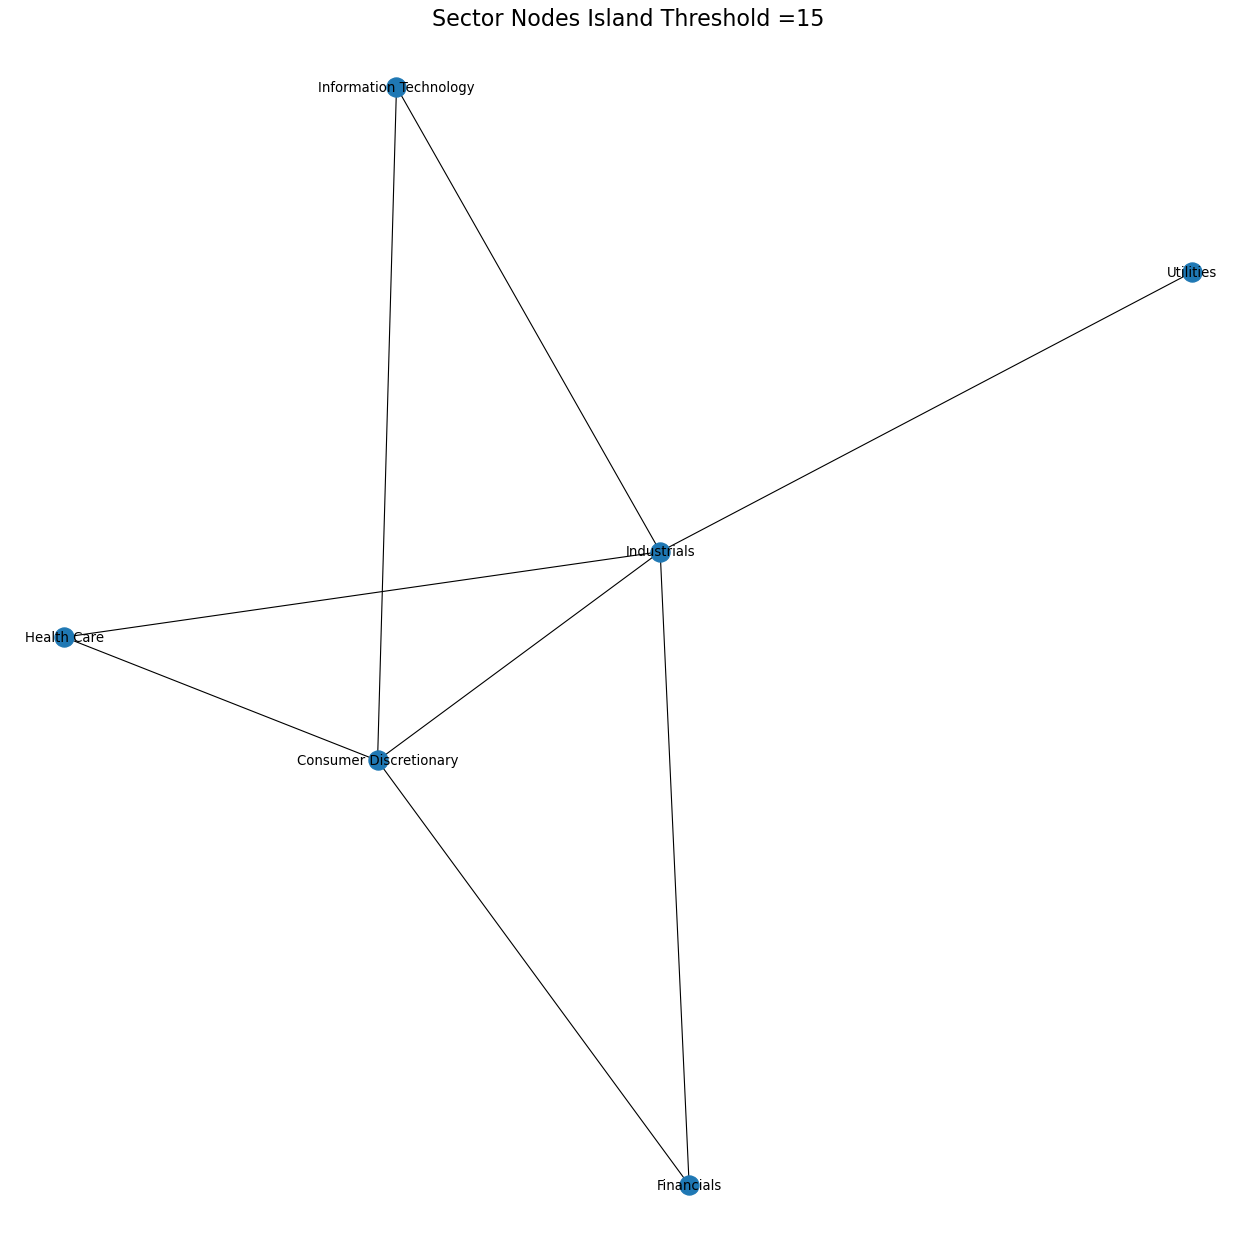

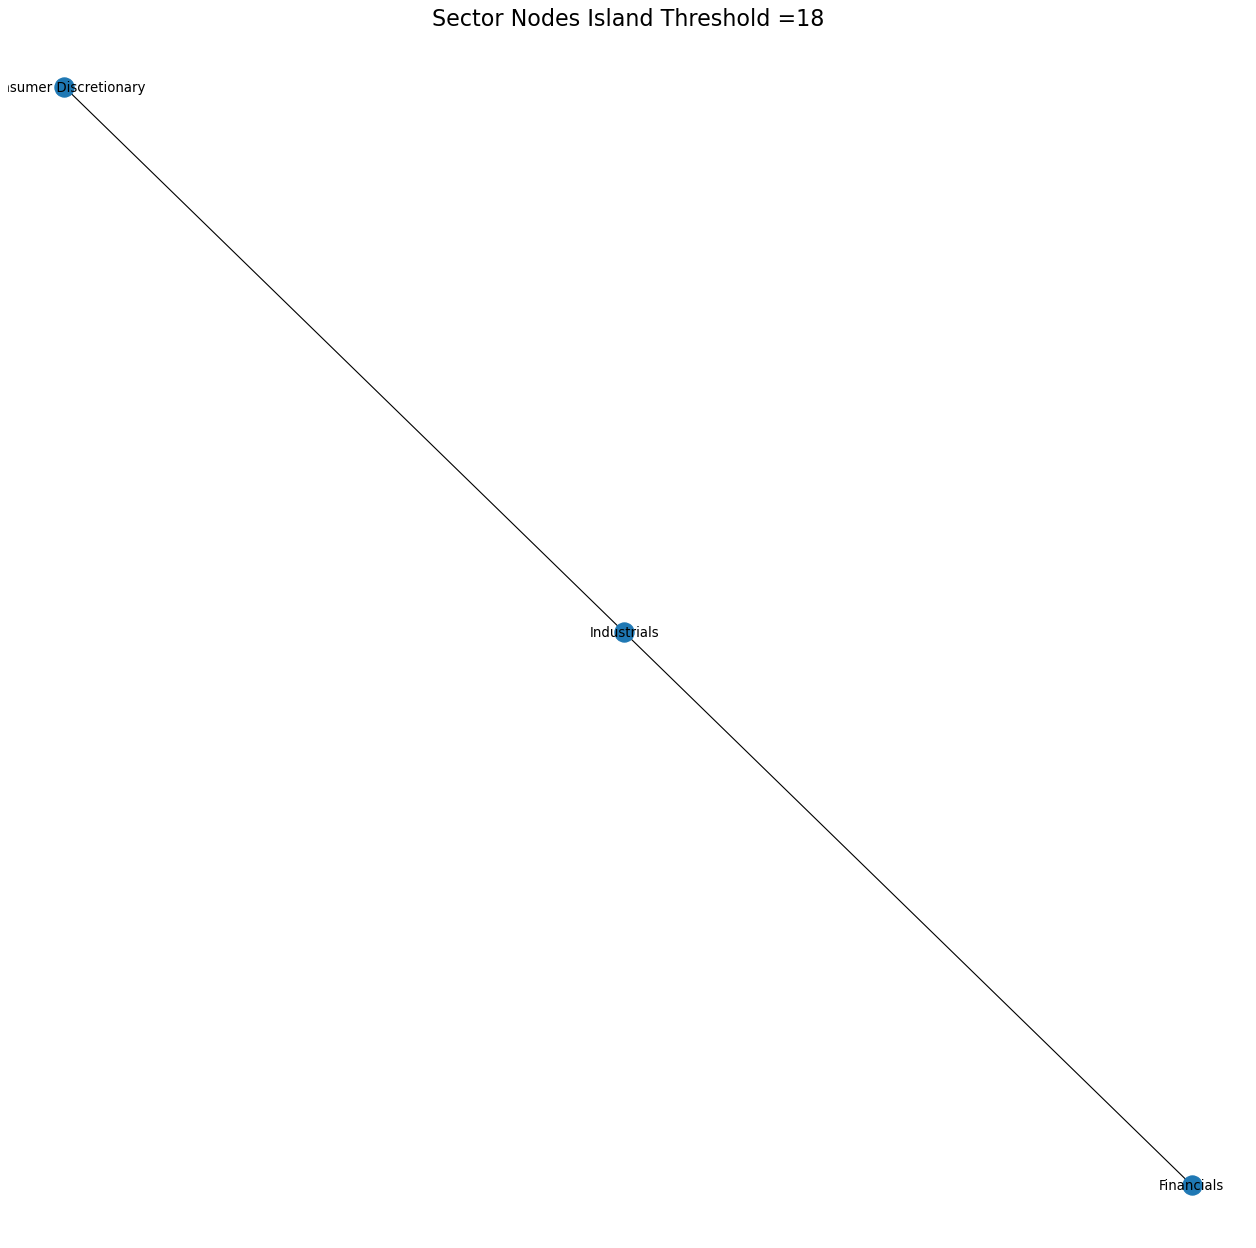

In [83]:
for i in range(len(state_island2)):
    #Visualize sub-networks (islands)
    pos = nx.spring_layout(state_island2[i][1])
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    nx.draw_networkx_nodes(state_island2[i][1],pos)
    nx.draw_networkx_edges(state_island2[i][1],pos)
    nx.draw_networkx_labels(state_island2[i][1],pos)
    plt.title('Sector Nodes Island Threshold =' + str(state_island2[i][0]),size = 20)

    cut = 1.00
    plt.show()

#### Sector Projected Network - Island Method Analysis
As seen in the visualization above, the sectors within specific sub-networks are now begginig to cluster together. In each slice of the network we start to see less promonant sectors drop off until we reach the last graph where you can see that Consumer Discretion, Industrials and Financials are the most prominent nodes in this network - which agrees with previous analysis. It is interesting to note that in this perspective, we were able to confirm our initial conclusions whereas siumply by looking at centrality measures, we could not.

In [84]:
#FOR S&P DATA THERE IS ONLY AVAILABLE FORTHE PAST 10 YEARS AND NOT BEFORE
#Start date: June 30, 2011; End date: June 30, 2021
end = dt.date(2021, 6, 30)
start = dt.date(2011, end.month, end.day)

#GET LIST OF SYMBOLS FROM WEB SCRAPING SECTION ABOVE 
symList = list(df['Symbol'])

#changes to be made due to non matching of symbols
symList[64] = 'BRK-B' #from 'BRK.B'
symList[77]  = 'BF-A' #from BF.B

#puts all time series data for all companies in a list
yahooTimeData = []

deleted =[]
for i in symList:
    try:
        yahooTimeData.append(pd.DataFrame(reader.DataReader(i, 'yahoo', start=start, end=end)))
    except KeyError:
        deleted.append(i)
        pass

In [85]:
#preview yahoo data (first element)
print(yahooTimeData[0])

                  High         Low        Open       Close     Volume  \
Date                                                                    
2011-06-30   95.059998   93.349998   93.379997   94.849998  4201800.0   
2011-07-01   96.949997   94.830002   94.830002   96.669998  4659700.0   
2011-07-05   96.860001   96.059998   96.400002   96.139999  3064200.0   
2011-07-06   97.500000   96.099998   96.120003   97.239998  3704100.0   
2011-07-07   98.190002   97.169998   97.730003   97.970001  3312100.0   
...                ...         ...         ...         ...        ...   
2021-06-24  193.740005  191.639999  193.300003  193.259995  2191800.0   
2021-06-25  195.330002  193.300003  193.419998  194.750000  6175500.0   
2021-06-28  196.919998  194.389999  195.759995  196.500000  2100500.0   
2021-06-29  197.830002  195.720001  196.199997  196.029999  1858000.0   
2021-06-30  198.979996  195.539993  195.899994  198.630005  2592000.0   

             Adj Close  
Date                    


In [86]:
#print the companies that were deleted from the list due to error
for i in deleted:
    yahooTimeData.append(pd.DataFrame(reader.DataReader(i, 'yahoo', start=start, end=end)))

In [87]:

#remove items from the list and append them at the end to preserve index and company symbol
for i in deleted:
    symList.remove(i) 
    symList.append(i)

In [88]:
# set up two tables - one for volume and one for adjusted closing prices. 
# each table has the table with dates on the left and metric on the right

#create lists to hold dataframes with time series of stock data for each company
vol = []
adjClose = []
j = 0;
#seperate into list of dataframes with the name of company as the column
for i in yahooTimeData:
    vol.append(pd.DataFrame({symList[j]:i['Volume'].values}, index = i.index))
    adjClose.append(pd.DataFrame({symList[j]:i['Adj Close'].values}, index = i.index))
    j+=1
    
#create one giant dataframe with volumes (companies as columns)
volDF = pd.DataFrame(index = vol[0].index) #set the index
for i in vol:
    volDF = volDF.merge(i, how='outer',on='Date')
print(volDF.head())

                  MMM         ABT  ABBV    ABMD         ACN       ATVI  \
Date                                                                     
2011-06-30  4201800.0  12069400.0   NaN  195000   9807200.0  6501800.0   
2011-07-01  4659700.0  11558500.0   NaN  217400   8136500.0  3530600.0   
2011-07-05  3064200.0  10492400.0   NaN   86000  89655900.0  2994700.0   
2011-07-06  3704100.0   7447800.0   NaN  127800  15294600.0  6093900.0   
2011-07-07  3312100.0  10280300.0   NaN  136500  13973000.0  7370700.0   

               ADBE       AMD        AAP        AES  ...      WLTW       WYNN  \
Date                                                 ...                        
2011-06-30  5519700  25379100  1452200.0  6323300.0  ...  308900.0  2006900.0   
2011-07-01  4218400  27641600   811200.0  3636300.0  ...  295800.0  2573700.0   
2011-07-05  3513400  16220600  1013000.0  7324500.0  ...  235400.0  1548900.0   
2011-07-06  2873100  13087600  1002200.0  6736300.0  ...  273900.0  1790500.

In [89]:
#create one giant dataframe with adjusted closing prices
adjCloseDF = pd.DataFrame(index = adjClose[0].index) #set the index
for i in adjClose:
    adjCloseDF = adjCloseDF.merge(i, how='outer',on='Date')
print(adjCloseDF.head())

                  MMM        ABT  ABBV       ABMD        ACN       ATVI  \
Date                                                                      
2011-06-30  72.144760  20.276722   NaN  16.200001  48.905159  10.718831   
2011-07-01  73.529076  20.461695   NaN  16.750000  49.269402  10.865664   
2011-07-05  73.125938  20.484806   NaN  16.700001  49.981693  10.828955   
2011-07-06  73.962624  20.531042   NaN  16.920000  50.264996  10.975789   
2011-07-07  74.517860  20.631241   NaN  16.850000  51.349613  11.049207   

                 ADBE   AMD        AAP       AES  ...       WLTW        WYNN  \
Date                                              ...                          
2011-06-30  31.450001  6.99  56.537373  9.662763  ...  88.458389  102.594597   
2011-07-01  31.530001  7.11  57.126995  9.844795  ...  88.716621  106.904518   
2011-07-05  31.520000  7.14  56.469700  9.738611  ...  88.587517  108.040955   
2011-07-06  31.650000  7.00  56.170059  9.837213  ...  89.190010  109.5633

In [90]:
#calculate correlation between columns
volCorr = volDF.corr()
adjCloseCorr = adjCloseDF.corr()

In [91]:

#Display volume correlation matrix
print(volCorr.head())

           MMM       ABT      ABBV      ABMD       ACN      ATVI      ADBE  \
MMM   1.000000  0.356905  0.273699  0.093794  0.285494  0.151497  0.427850   
ABT   0.356905  1.000000  0.178783  0.040610  0.279877  0.149130  0.351629   
ABBV  0.273699  0.178783  1.000000  0.133408  0.186971  0.086956  0.170822   
ABMD  0.093794  0.040610  0.133408  1.000000 -0.001140  0.079318  0.026044   
ACN   0.285494  0.279877  0.186971 -0.001140  1.000000  0.070098  0.285666   

           AMD       AAP       AES  ...      WLTW      WYNN       XEL  \
MMM   0.052173  0.062730  0.265877  ...  0.090008  0.242947  0.285835   
ABT  -0.125001  0.036312  0.113742  ...  0.020952  0.104142  0.094888   
ABBV -0.026824  0.010952  0.103789  ...  0.048919  0.170357  0.197567   
ABMD  0.057220  0.050187  0.069013  ...  0.043769  0.058258  0.117989   
ACN  -0.103845  0.007916  0.114445  ... -0.010015  0.033904  0.134284   

          XLNX       XYL       YUM      ZBRA       ZBH      ZION       ZTS  
MMM   0.341356 

In [92]:
#Create Initial Network (Volume)
#extracts the indices from the correlation matrix (stock code names)
indexVol = volCorr.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
volCorrMatrix = np.asmatrix(volCorr)

######CREATE NETWORK GRAPH FROM CORRELATION MATRIX###
#Crates graph using the data of the correlation matrix
Gvol = nx.from_numpy_matrix(volCorrMatrix)

#relabels the nodes to match thestocks names
Gvol = nx.relabel_nodes(Gvol,lambda x: indexVol[x])

#copy of edges and weights
Gvol_edges = Gvol.copy()
Gvol_edges = Gvol_edges.edges(data = True)

#remove self correlations
for stock_1, stock_2, weights in Gvol_edges:
    if stock_1 == stock_2:
        Gvol.remove_edge(stock_1, stock_2)

#shows first 10 edges with their corresponding weights
list(Gvol.edges(data=True))[0:10]

[('MMM', 'ABT', {'weight': 0.356905491068391}),
 ('MMM', 'ABBV', {'weight': 0.2736990350825697}),
 ('MMM', 'ABMD', {'weight': 0.09379407628808412}),
 ('MMM', 'ACN', {'weight': 0.28549427919015447}),
 ('MMM', 'ATVI', {'weight': 0.15149717099097287}),
 ('MMM', 'ADBE', {'weight': 0.427849585469155}),
 ('MMM', 'AMD', {'weight': 0.052172523866042875}),
 ('MMM', 'AAP', {'weight': 0.06273042367781606}),
 ('MMM', 'AES', {'weight': 0.26587748512766196}),
 ('MMM', 'AFL', {'weight': 0.46846303994995814})]

In [93]:
#Create Initial Network (Adjusted Closing)
#extracts the indices from the correlation matrix (stock code names)
indexClose = adjCloseCorr.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
closeCorrMatrix = np.asmatrix(adjCloseCorr)

#Crates graph using the data of the correlation matrix
Gclose = nx.from_numpy_matrix(closeCorrMatrix)

#relabels the nodes to match thestocks names
Gclose = nx.relabel_nodes(Gclose,lambda x: indexClose[x])

#copy of edges and weights
Gclose_edges = Gclose.copy()
Gclose_edges = Gclose_edges.edges(data = True)

#remove self correlations
for stock_1, stock_2, weights in Gclose_edges:
    if stock_1 == stock_2:
        Gclose.remove_edge(stock_1, stock_2)
#shows the first 10 edges with their corresponding weights
list(Gclose.edges(data=True))[0:10]

[('MMM', 'ABT', {'weight': 0.6681992878880171}),
 ('MMM', 'ABBV', {'weight': 0.8003624443074675}),
 ('MMM', 'ABMD', {'weight': 0.8147607402140442}),
 ('MMM', 'ACN', {'weight': 0.751487400192697}),
 ('MMM', 'ATVI', {'weight': 0.8430184478050646}),
 ('MMM', 'ADBE', {'weight': 0.667701431849676}),
 ('MMM', 'AMD', {'weight': 0.4597469879581895}),
 ('MMM', 'AAP', {'weight': 0.6704100142819991}),
 ('MMM', 'AES', {'weight': 0.4814890483920909}),
 ('MMM', 'AFL', {'weight': 0.8549613814237398})]

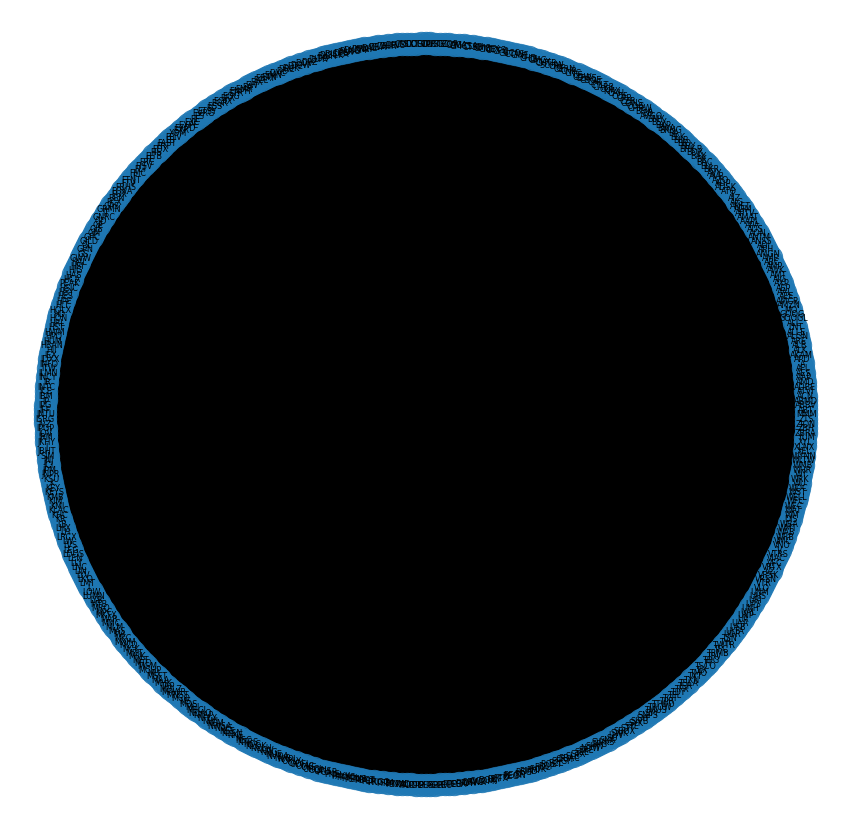

In [96]:
#function to create and display networks from the correlatin matrix. 
def create_corr_network_1(G):
    #crates a list for edges and for the weights
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    #positions
    positions=nx.circular_layout(G)
    
    #Figure size
    plt.figure(figsize=(15,15))

    #draws nodes
    nx.draw_networkx_nodes(G,positions,node_size=500,alpha=0.8)
    
    #Styling for labels
    nx.draw_networkx_labels(G, positions, font_size=8, 
                            font_family='sans-serif')
        
    #draws the edges
    nx.draw_networkx_edges(G, positions,style='solid')
    
    # displays the graph without axis
    plt.axis('off')
    plt.show() 

create_corr_network_1(Gvol)

In [97]:

print(nx.info(Gvol))

Name: 
Type: Graph
Number of nodes: 504
Number of edges: 126756
Average degree: 503.0000


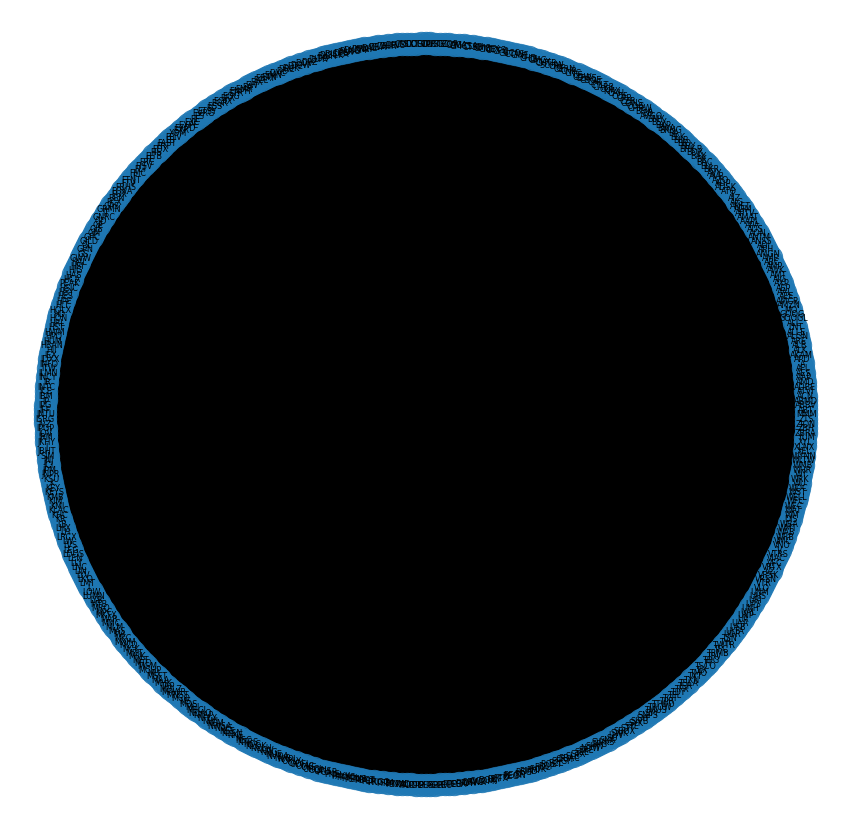

In [98]:
create_corr_network_1(Gclose)

In [99]:
print(nx.info(Gclose))

Name: 
Type: Graph
Number of nodes: 504
Number of edges: 126756
Average degree: 503.0000



From these initial networks we cannot really see any patterns between members because it is oversaturated with many nodes ande many edges. Below we employ some network reduction techniques to get a better sense of the positive correlations in the network. First we seperate the Volume and Adjusted Closing price into positive and negative correlation networks, then we use the island method to discover groupings of similar nodes that have similar correlations (highly correlated).

In [104]:
#seperate between positive and negative correlations
def create_corr_network_PN(G):

    #Creates a copy of the graph
    H = G.copy()
    I = G.copy()

    #Checks all the edges and removes some based on corr_direction
    for stock1, stock2, weight in G.edges(data=True):
        #for positive delete the edges with weight smaller than 0
        if weight["weight"] < 0:
            H.remove_edge(stock1, stock2)
        #for negative delete edges with weights equal or less more than 0
        else:
            if weight["weight"] >= 0:
                I.remove_edge(stock1, stock2)
    return H, I

###Plotting function
def plot_stock_network(G, corr_direction, nodeHEXColor):
    #crates a list for edges and for the weights
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    
    #positions
    positions=nx.circular_layout(G)
    
    #Figure size
    plt.figure(figsize=(15,15))

    #draws nodes
    nx.draw_networkx_nodes(G,positions,node_color=nodeHEXColor,
                           node_size=500,alpha=0.8)
    
    #Styling for labels
    nx.draw_networkx_labels(G, positions, font_size=8, 
                            font_family='sans-serif')
        
    #draws the edges
    nx.draw_networkx_edges(G, positions,style='solid')
    
    # displays the graph without axis
    plt.axis('off')
    plt.title('S&P Stock Correlation Network ' + corr_direction)
    plt.show()
 


In [105]:
#create the networks Volume
posVol, negVol = create_corr_network_PN(Gvol)
#create the networks Adjusted Closing
posClose, negClose = create_corr_network_PN(Gclose)

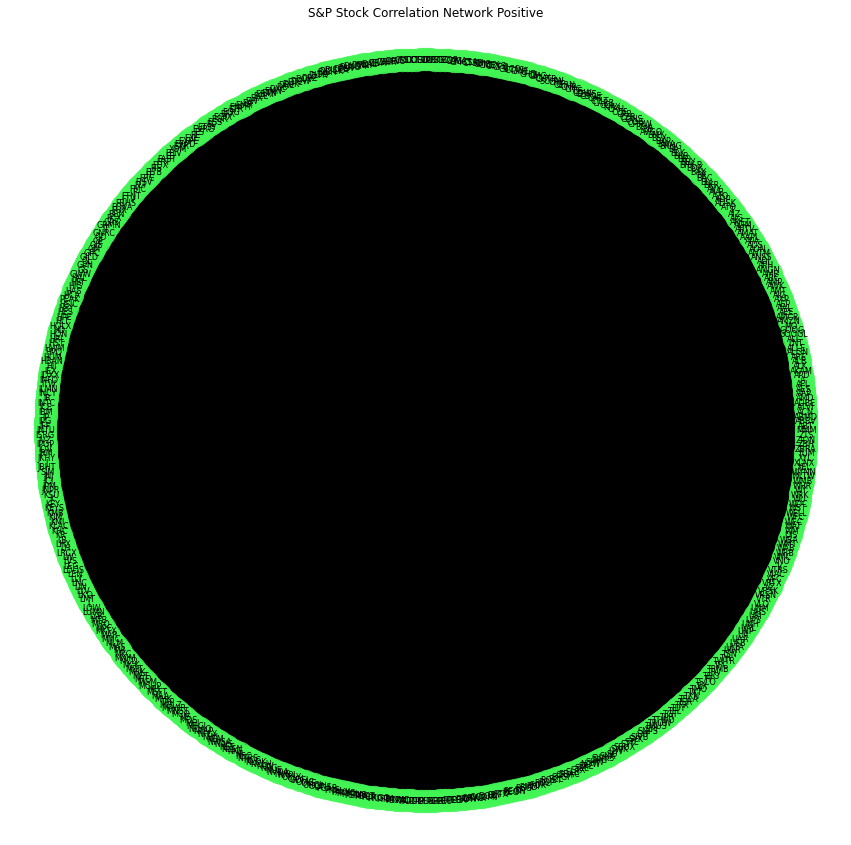

In [106]:
#plot posistive Network -  Volume
plot_stock_network(posVol, "Positive","#42f554")

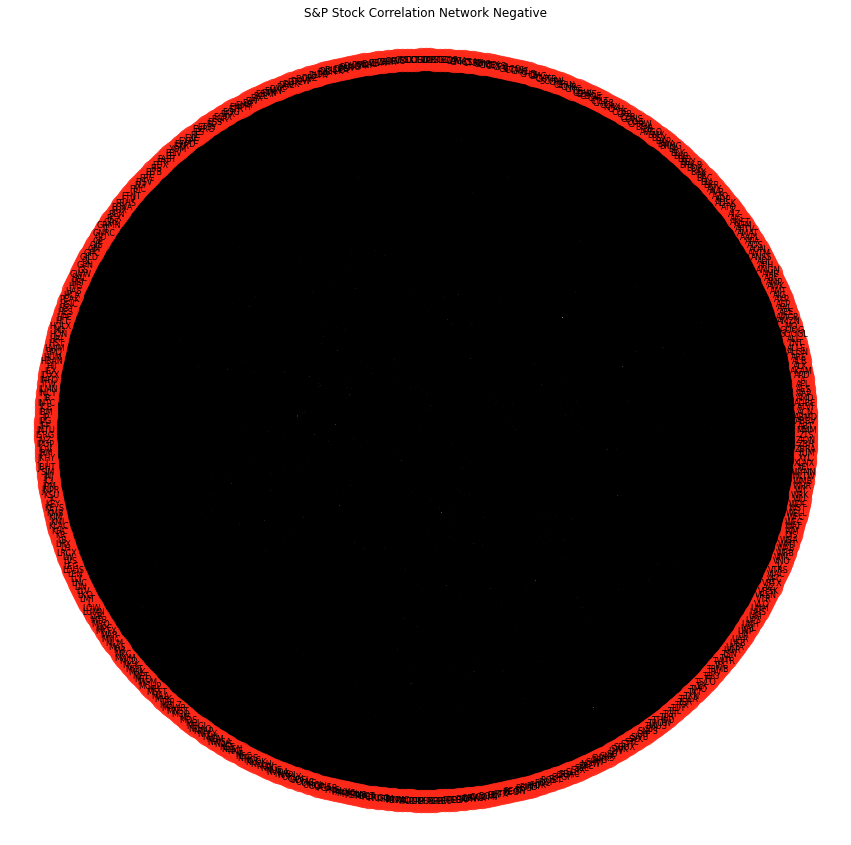

In [107]:
#plot negative Network - Volume
plot_stock_network(negVol, "Negative",'#ff2919')

These networks still look oversaturated and we cant really tell anything about each network still. We reduce the network further using a trimming method that focuses on retaining edges within a certain correlation coefficient. For our analysis for the volume network we chose to visualze the network with all edges that are above 60% correlation and 80% correlation.

In [108]:
#Trim Edges (any correlation below a certain decimal percent
def trim_edges2(G, decPercent):
    H = nx.Graph()
    for stock_1, stock_2, weight in G.edges(data=True): #checks if the value is less that decimal percent specified
        if abs(weight["weight"]) > decPercent:
            H.add_edge(stock_1, stock_2, weight = weight["weight"])
    return H

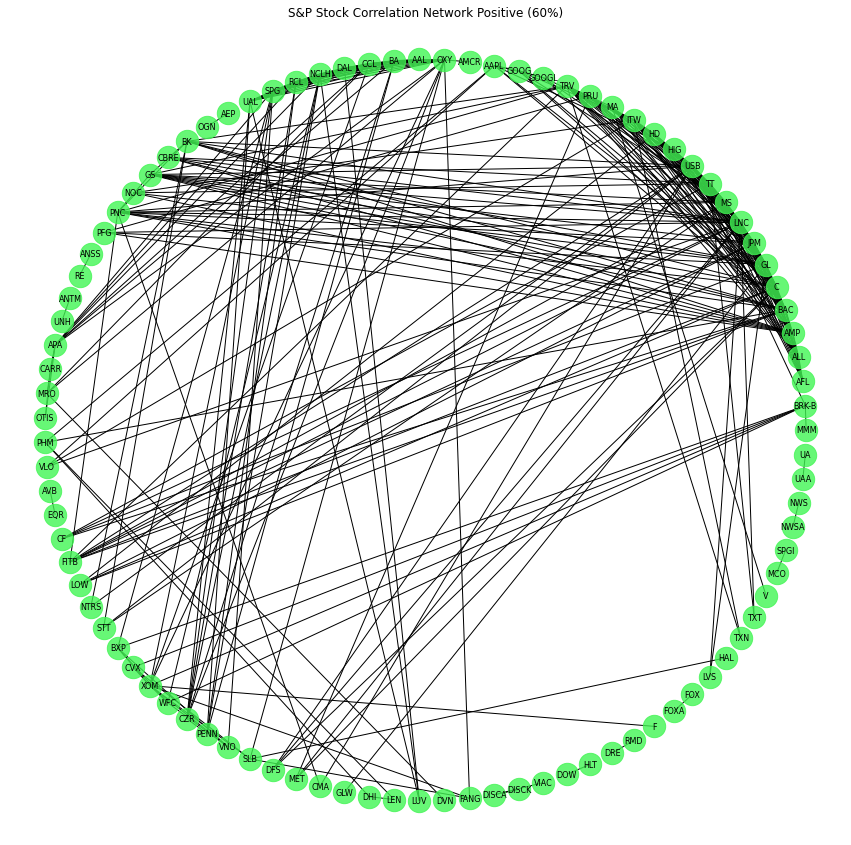

In [109]:
#VOLUME - Positive - 60%
posVol60 = trim_edges2(posVol, 0.6)
#plot network
plot_stock_network(posVol60, "Positive (60%)","#42f554")

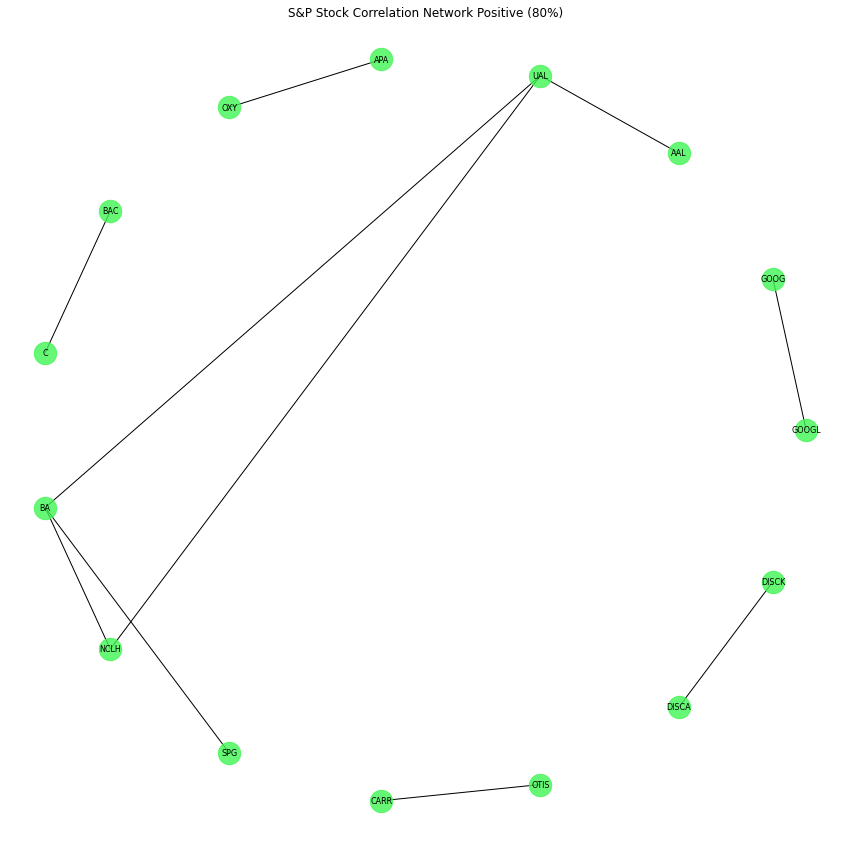

In [110]:
#VOLUME - Positive - 80%
posVol80 = trim_edges2(posVol, 0.8)
#plot network
plot_stock_network(posVol80, "Positive (80%)","#42f554")

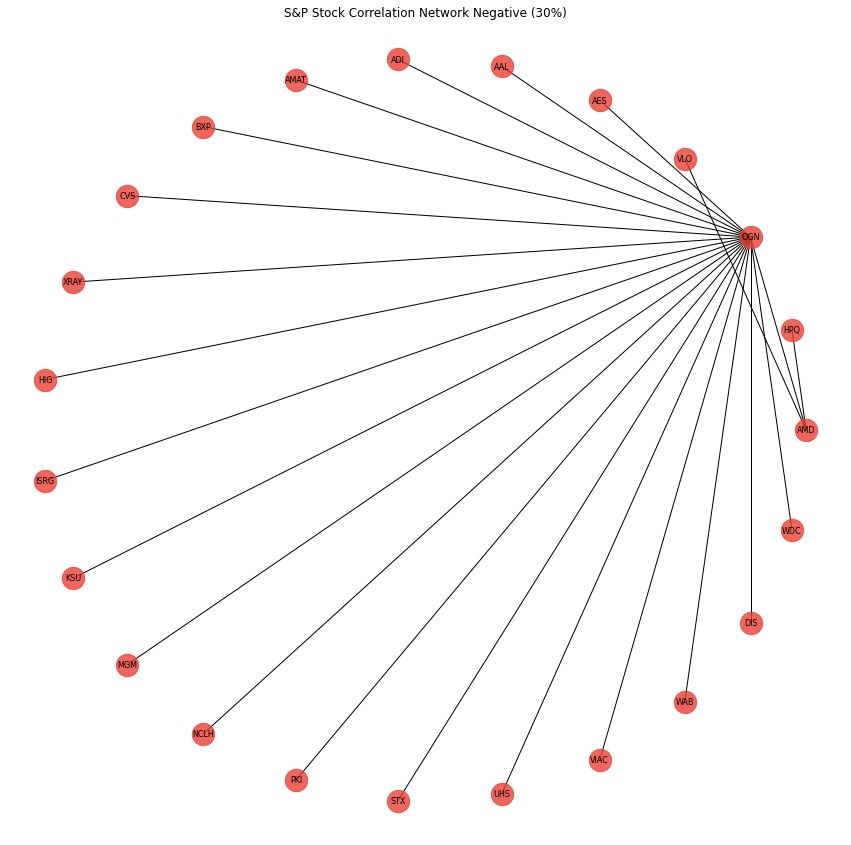

In [111]:
#Volume - Negative - 30% (highest negative correlation)
negVol30 = trim_edges2(negVol, 0.3)
#plot network
plot_stock_network(negVol30, "Negative (30%)","#eb4034")

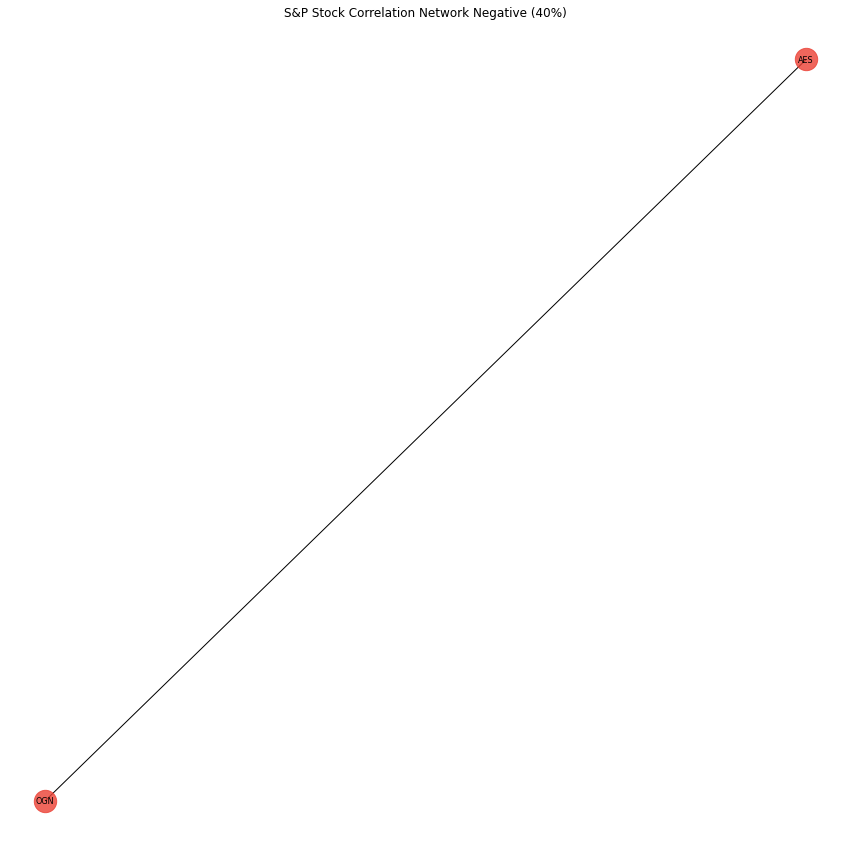

In [112]:
#Volume - Negative - 40% (highest negative correlation)
negVol40 = trim_edges2(negVol, 0.4)
#plot network
plot_stock_network(negVol40, "Negative (40%)","#eb4034")

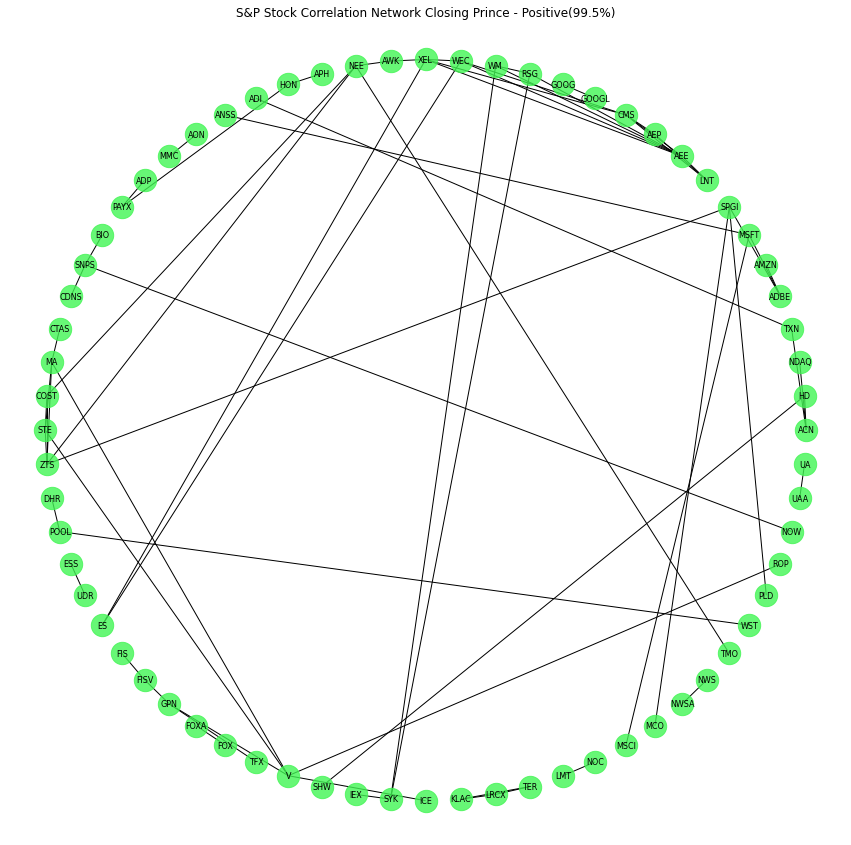

In [113]:

#Adjusted Closing - Positive - 99%
posClose99 = trim_edges2(posClose, 0.99)
#plot network
plot_stock_network(posClose99, "Closing Prince - Positive(99.5%)","#42f554")

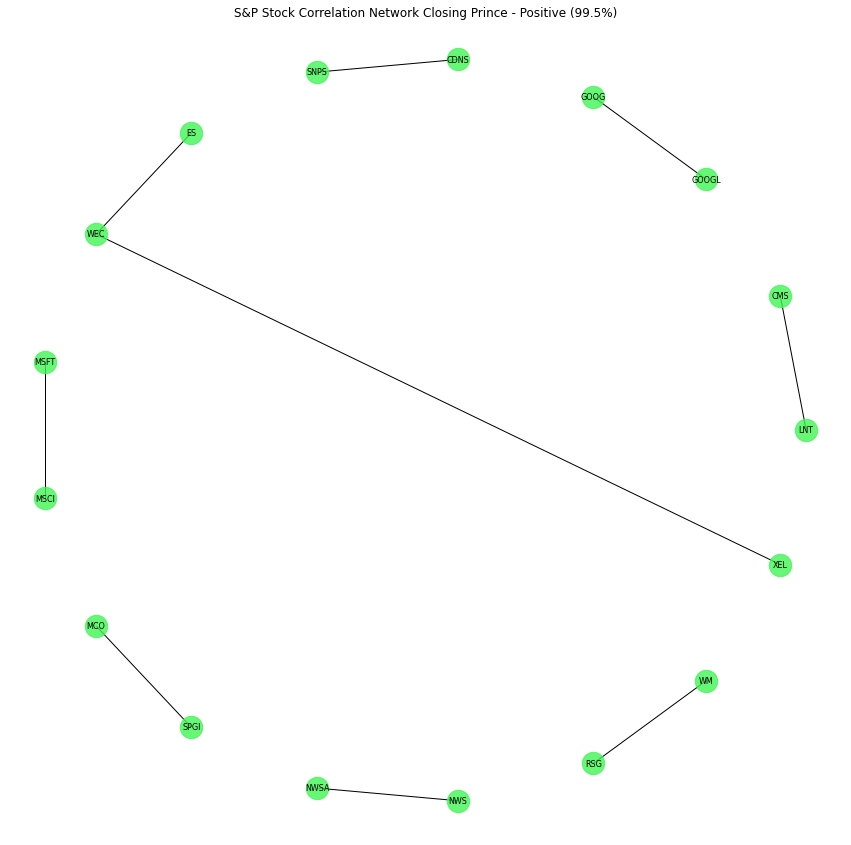

In [114]:
#Adjusted Closing - Positive - 99.5%
posClose995 = trim_edges2(posClose, 0.995)
#plot network
plot_stock_network(posClose995, "Closing Prince - Positive (99.5%)","#42f554")

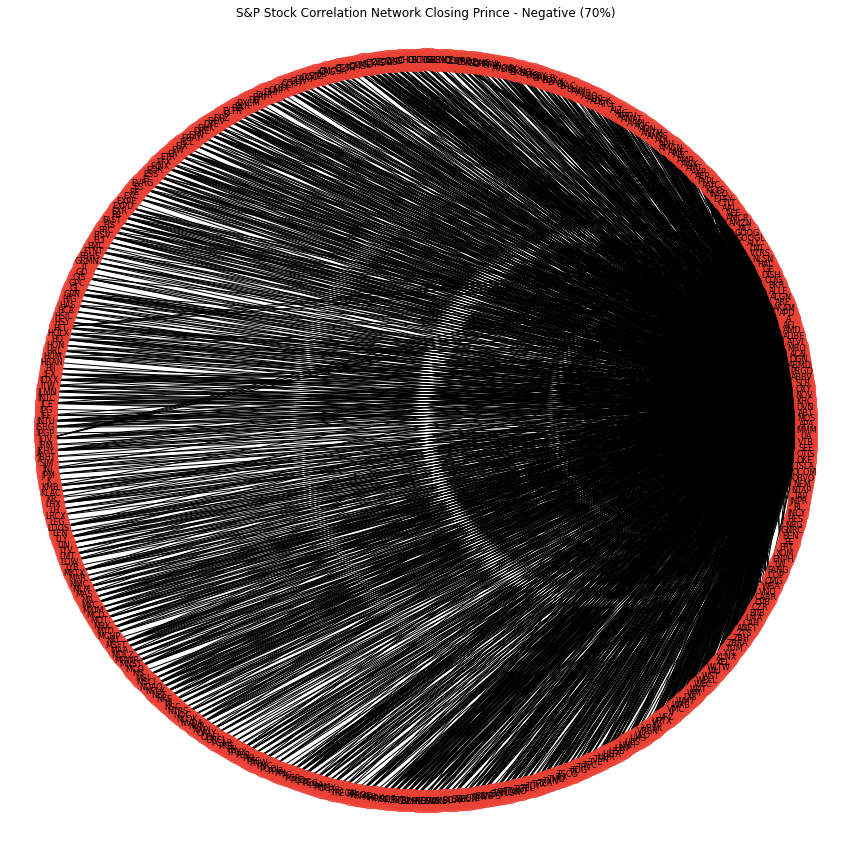

In [115]:
#Adjusted Closing - Negative - 70%
negClose70 = trim_edges2(negClose, 0.7)
#plot Network 
plot_stock_network(negClose70, "Closing Prince - Negative (70%)","#eb4034")

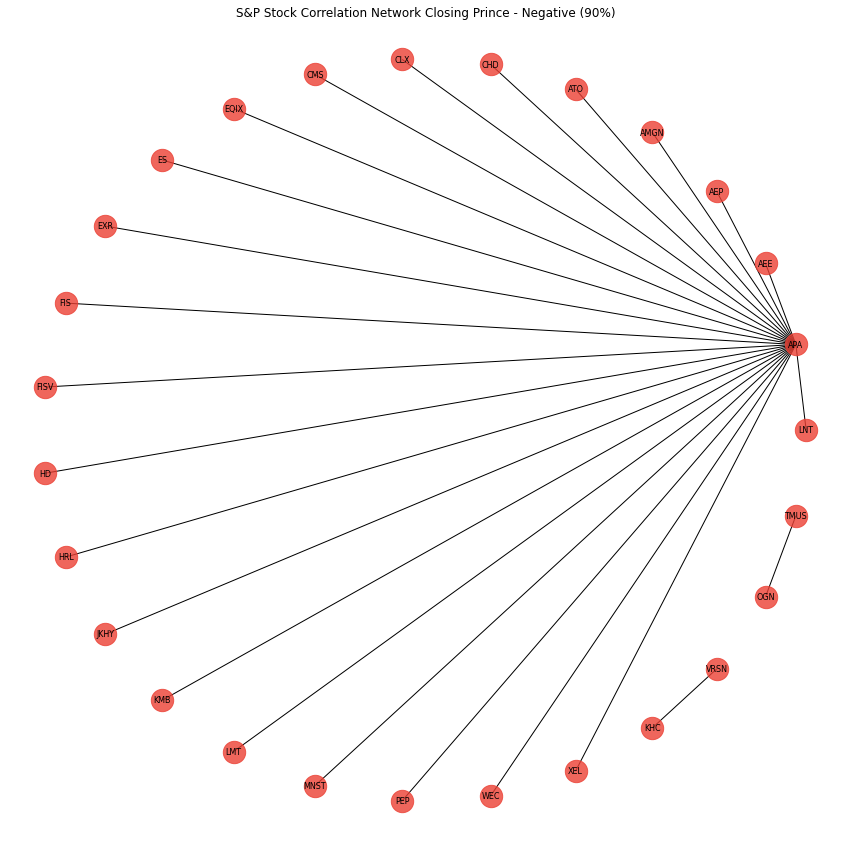

In [116]:
#Adjusted Closing - Negative - 90%
negClose90 = trim_edges2(negClose, 0.9)
#plot Network 
plot_stock_network(negClose90, "Closing Prince - Negative (90%)","#eb4034")


Centrality Measures
To help us get a quantitive idea of the relationship between nodes, we calculated measures of centrality and sorted them in the table using the same method as in the previous section (with wiki data).

In [117]:
#closeness (Volume)
volClose = nx.closeness_centrality(Gvol)
#betweenness  (Volume)
volBet = nx.betweenness_centrality(Gvol)
#eigenvector  (Volume)
volEig = nx.eigenvector_centrality(Gvol)

#put everything in a dataframe for easy comparison
VOLclosenessDF = pd.DataFrame.from_dict(volClose.items())
VOLclosenessDF.rename(columns={0: 'Company',1: 'Closeness'},inplace=True, errors='raise')

VOLbetweennessDF = pd.DataFrame.from_dict(volBet.items())
VOLbetweennessDF.rename(columns={0: 'Company',1: 'Betweenness'},inplace=True, errors='raise')

VOLeigenvectorDF = pd.DataFrame.from_dict(volEig.items())
VOLeigenvectorDF.rename(columns={0: 'Company',1: 'Eigenvector'},inplace=True, errors='raise')

In [118]:
VOLcentDF = VOLclosenessDF.merge(VOLbetweennessDF, how='outer',on='Company')
VOLcentDF = VOLcentDF.merge(VOLeigenvectorDF, how='outer',on='Company')
VOLcentDF.sort_values(by=['Closeness'],ascending=False)[0:10]

Company  Closeness  Betweenness  Eigenvector
0       MMM        1.0          0.0     0.044544
331     NEM        1.0          0.0     0.044544
344     NRG        1.0          0.0     0.044544
343     NOV        1.0          0.0     0.044544
342    NCLH        1.0          0.0     0.044544
341    NLOK        1.0          0.0     0.044544
340     NOC        1.0          0.0     0.044544
339    NTRS        1.0          0.0     0.044544
338     NSC        1.0          0.0     0.044544
337      NI        1.0          0.0     0.044544

In [119]:
#closeness (VADJCLOSING)
adjClose = nx.closeness_centrality(Gclose)
#betweenness  (Volume)
adjBet = nx.betweenness_centrality(Gclose)
#eigenvector  (Volume)
adjEig = nx.eigenvector_centrality(Gclose)

#put everything in a dataframe for easy comparison
ADJclosenessDF = pd.DataFrame.from_dict(adjClose.items())
ADJclosenessDF.rename(columns={0: 'Company',1: 'Closeness'},inplace=True, errors='raise')

ADJbetweennessDF = pd.DataFrame.from_dict(adjBet.items())
ADJbetweennessDF.rename(columns={0: 'Company',1: 'Betweenness'},inplace=True, errors='raise')

ADJeigenvectorDF = pd.DataFrame.from_dict(adjEig.items())
ADJeigenvectorDF.rename(columns={0: 'Company',1: 'Eigenvector'},inplace=True, errors='raise')

ADJcentDF = ADJclosenessDF.merge(ADJbetweennessDF, how='outer',on='Company')
ADJcentDF = ADJcentDF.merge(ADJeigenvectorDF, how='outer',on='Company')
ADJcentDF.sort_values(by=['Closeness'],ascending=False)[0:10]

Company  Closeness  Betweenness  Eigenvector
0       MMM        1.0          0.0     0.044544
331     NEM        1.0          0.0     0.044544
344     NRG        1.0          0.0     0.044544
343     NOV        1.0          0.0     0.044544
342    NCLH        1.0          0.0     0.044544
341    NLOK        1.0          0.0     0.044544
340     NOC        1.0          0.0     0.044544
339    NTRS        1.0          0.0     0.044544
338     NSC        1.0          0.0     0.044544
337      NI        1.0          0.0     0.044544

In [120]:
#Number of Connections for positive correlated network above 80%
pd.DataFrame(list(posVol80.degree()))

0  1
0   GOOGL  1
1    GOOG  1
2     AAL  1
3     UAL  3
4     APA  1
5     OXY  1
6     BAC  1
7       C  1
8      BA  3
9    NCLH  2
10    SPG  1
11   CARR  1
12   OTIS  1
13  DISCA  1
14  DISCK  1

Correlation Networks Analysis
As we can see in the above correlation network analysis, networks associated with positive and negative correlations behave differently when it comes to correlations between Volume and Adjusted Closing Prices. For this specific project we focused on identfying the company with the highest correlation to other companies based on their stock volume behavior over time. As seen in the Positive 80% network visualization and print out of edges above, the Boeing company leads in that it is highly positivley correlated to the most companies in the S&P500. This leads us to our next section conducting sentiment analysis.

Boeing Company Twitter Analysis
As stated above we chose Boeing as a company to conduct some twitter analysis for because in our analysis it showed to be a node that contained more connections in the highly correlated network, than any other company. It is strongly connected to other airlies and energy companies. Twitter data regarding Boeing was accessed through the Twitter API.